# Project: Cause of death in the United States

#### Importing libraries

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from google.colab import drive #mounted my google drive folder onto my Juypter notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Loading in the data from downloaded .csv files from https://www.kaggle.com/datasets/cdc/mortality 

In [202]:
#fulldf = pd.read_csv('comprehensive_df.csv')
fulldf = pd.read_csv('/content/drive/MyDrive/Data Wrangling/comprehensive_df.csv')

<ipython-input-202-77b68d0ce3e6>:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  fulldf = pd.read_csv('/content/drive/MyDrive/Data Wrangling/comprehensive_df.csv')


#### What does the dataset look like?

- In another notebook that is hooked up to the school computer I used the gpu to create a new csv file combining all the datasets on the columns that had the least amount of nan values
- Originally there was a dataset for every year: 2005, 2006, 2007, etc. until 2015. Each one of these datasets had around 4 million or more samples as well as 78 total columns. To save on computing power and time I took a random sample of 100,000 entries per each dataset wich ended in 1,100,000 total samples once the datasets were combined. 
- I cut down on the amount of columns, specifically the ones made up of more than 30% nan values. This left me with 34 columns 
- Columns range from residential status of the deceased to, month of death, how they died, their sex, and many others. 

In [203]:
fulldf.columns

Index(['resident_status', 'education_1989_revision',
       'education_reporting_flag', 'month_of_death', 'sex', 'detail_age_type',
       'detail_age', 'age_recode_52', 'age_recode_27', 'age_recode_12',
       'place_of_death_and_decedents_status', 'marital_status',
       'day_of_week_of_death', 'current_data_year', 'injury_at_work',
       'manner_of_death', 'method_of_disposition', 'autopsy',
       'icd_code_10th_revision', '358_cause_recode', '113_cause_recode',
       '39_cause_recode', 'number_of_entity_axis_conditions',
       'entity_condition_1', 'entity_condition_2', 'entity_condition_3',
       'number_of_record_axis_conditions', 'record_condition_1',
       'record_condition_2', 'race', 'race_recode_3', 'race_recode_5',
       'hispanic_origin', 'hispanic_originrace_recode', 'Year'],
      dtype='object')

In [204]:
fulldf.head()

,resident_status,education_1989_revision,education_reporting_flag,month_of_death,sex,detail_age_type,detail_age,age_recode_52,age_recode_27,age_recode_12,...,entity_condition_3,number_of_record_axis_conditions,record_condition_1,record_condition_2,race,race_recode_3,race_recode_5,hispanic_origin,hispanic_originrace_recode,Year
0,1.0,NaN,1.0,9.0,M,1.0,86.0,43.0,23.0,11.0,...,22I619,4.0,I469,I619,1.0,1.0,1.0,100.0,6.0,2005
1,1.0,NaN,1.0,12.0,M,1.0,68.0,39.0,19.0,9.0,...,31G35,4.0,G35,I251,1.0,1.0,1.0,100.0,6.0,2005
2,1.0,NaN,1.0,1.0,F,1.0,85.0,43.0,23.0,11.0,...,NaN,1.0,C189,NaN,1.0,1.0,1.0,100.0,6.0,2005
3,1.0,NaN,1.0,9.0,F,1.0,42.0,34.0,14.0,6.0,...,21I269,4.0,C20,I269,1.0,1.0,1.0,100.0,6.0,2005
4,1.0,NaN,1.0,4.0,M,1.0,76.0,41.0,21.0,10.0,...,NaN,1.0,R99,NaN,2.0,3.0,2.0,100.0,7.0,2005


#### Converting numbers to causes
- My first issue is converting all the numbers back into what they symbolize
- I created a dictionary for 358_cause_recode which is an extremely specific cause of death
- I also created dictionaries for 39_cause_recode which is a more generalized cause of death, as well as the manner that the person died, where they died, what their marital status was, day of the week, and education status

All of these dictionaries were created from the legends provided to me from the .json files in the kaggle repository associated with each year

#### Updating the dataframe columns

In [205]:
#Specific cause of death dictionary #I have to do these for all of them!!
recode358 = dict({"001": "I. Certain infectious and parasitic diseases (A00-B99)", "002": "Intestinal infectious diseases (A00-A09)", "003": "Cholera (A00)", "004": "Other intestinal infectious diseases (A01-A08)", "005": "Typhoid fever (A01.0)", "006": "Paratyphoid fevers and other salmonella infections (A01.1-A01.4,A02)", "007": "Shigellosis (A03)", "008": "Other bacterial food-borne intoxications (A05)", "009": "Amebiasis (A06)", "010": "Intestinal infections due to other specified organisms (A04,A07-A08)", "011": "Diarrhea and gastroenteritis of infectious origin (A09)", "012": "Tuberculosis (A16-A19)", "013": "Respiratory tuberculosis (A16)", "014": "Other tuberculosis (A17-A19)", "015": "Zoonotic and other bacterial diseases (A20-A49)", "016": "Plague (A20)", "017": "Brucellosis (A23)", "018": "Tetanus (A33-A35)", "019": "Diptheria (A36)", "020": "Whooping cough (A37)", "021": "Scarlet fever and erysipelas (A38,A46)", "022": "Meningococcal infection (A39)", "023": "Septicemia (A40-A41)", "024": "Other zoonotic and bacterial diseases (A21-A22,A24-A32,A42-A44, A48-A49)", "025": "Infections with a predominately sexual mode of transmission (A50-A64)", "026": "Syphilis (A50-A53)", "027": "Cardiovascular syphilis (A52.0)", "028": "Neurosyphilis (A52.1-A52.3)", "029": "Other and unspecified syphilis (A50-A51,A52.7-A52.9,A53)", "030": "Gonococcal infection (A54)", "031": "Other infections with a predominately sexual mode of transmission (A55-A64)", "032": "Other infections caused by spirochetes, chlamydia or rickettsia (A65-A79)", "033": "Lyme disease (A69.2)", "034": "Typhus fever (A75)", "035": "All other infections caused by spirochetes, chlamydia or rickettsia (A65-A68,A69.0-A69.1,A69.8-A69.9,A70-A74,A77-A79)", "036": "Viral diseases (A80-B34)", "037": "Acute poliomyelitis (A80)", "038": "Rabies (A82)", "039": "Arthropod-borne viral encephalitis (A83-A84,A85.2)", "040": "Yellow fever (A95)", "041": "Other and unspecified arthropod-borne viral and hemorrhagic fevers (A90-A94,A96-A99)", "042": "Herpesviral (herpes simplex) infections (B00)", "043": "Zoster (herpes zoster) (B02)", "044": "Smallpox (B03)", "045": "Measles (B05)", "046": "Rubella (German measles) (B06)", "047": "Viral hepatitis (B15-B19)", "048": "Human immunodeficiency virus (HIV) disease (B20-B24)", "049": "Human immunodeficiency virus (HIV) disease resulting in infectious and parasitic diseases (B20)", "050": "Human immunodeficiency virus (HIV) disease resulting in malignant neoplasms (B21)", "051": "Human immunodeficiency virus (HIV) disease resulting in other specified diseases (B22)", "052": "Human immunodeficiency virus (HIV) disease resulting in other conditions (B23)", "053": "Unspecified human immunodeficiency virus (HIV) disease (B24)", "054": "All other and unspecified viral diseases (A81,A85.0-A85.1,A85.8, A86-A89,B01,B04,B07-B09,B25-B34)", "055": "Other and unspecified infectious and parasitic diseases and their sequelae (B35-B99)", "056": "Mycoses (B35-B49)", "057": "Protozoal diseases (B50-B64)", "058": "Malaria (B50-B54)", "059": "Leishmaniasis (B55)", "060": "Trypanosomiasis (B56-B57)", "061": "Pneumocystosis (B59)", "062": "Other and unspecified protozoal diseases (B58,B60-B64)", "063": "Helminthiases (B65-B83)", "064": "Schistosomiasis (bilharziasis) (B65)", "065": "Other and unspecified helminthiases (B66-B83)", "066": "Sequelae of tuberculosis (B90)", "067": "Sequelae of poliomyelitis (B91)", "068": "All other and unspecified infectious and parasitic diseases and their sequelae (B85-B89,B92-B99)", "069": "II. Neoplasms (C00-D48)", "070": "Malignant neoplasms (C00-C97)", "071": "Malignant neoplasms of lip, oral cavity and pharynx (C00-C14)", "072": "Of lip (C00)", "073": "Of tongue (C01-C02)", "074": "Of pharynx (C10-C13,C14.0)", "075": "Of other and unspecified sites within the lip, oral cavity and pharynx (C03-C09,C14.2-C14.8)", "076": "Malignant neoplasms of digestive organs (C15-C26)", "077": "Of esophagus (C15)", "078": "Of stomach (C16)", "079": "Of small intestine (C17)", "080": "Of colon, rectum and anus (C18-C21)", "081": "Colon (C18)", "082": "Rectosigmoid junction and rectum (C19-C20)", "083": "Anus and anus canal (C21)", "084": "Of liver and intrahepatic bile ducts (C22)", "085": "Liver (C22.0,C22.2-C22.9)", "086": "Intrahepatic bile duct carcinoma (C22.1)", "087": "Of gallbladder and extrahepatic bile ducts (C23-C24)", "088": "Of pancreas (C25)", 
      "089": "Of other and ill-defined digestive organs (C26)", "090": "Malignant neoplasms of respiratory and intrathoracic organs (C30-C39)", "091": "Of nasal cavity, middle ear and accessory sinuses (C30-C31)", "092": "Of larynx (C32)", "093": "Of trachea, bronchus and lung (C33-C34)", "094": "Of thymus, heart, mediastinum and pleura (C37-C38)", "095": "Of other and ill-defined sites in respiratory system and intrathoracic organs (C39)", "096": "Malignant neoplasms of bone and articular cartilage (C40-C41)", "097": "Melanoma and other malignant neoplasms of skin (C43-C44)", "098": "Malignant melanoma of skin (C43)", "099": "Other malignant neoplasms of skin (C44)", "100": "Malignant neoplasms of mesothelial and soft tissue (C45-C49)", "101": "Mesothelioma (C45)", "102": "Kaposi=s sarcoma (C46)", "103": "Of other mesothelial and soft tissue (C47-C49)", "104": "Malignant neoplasm of breast (C50)", "105": "Malignant neoplasms of female genital organs (C51-C58)", "106": "Of vulva and vagina (C51-C52)", "107": "Of cervix uteri (C53)", "108": "Of corpus uteri and uterus, part unspecified (C54-C55)", "109": "Of ovary (C56)", "110": "Of other and unspecified female genital organs (C57)", "111": "Of placenta (C58)", "112": "Malignant neoplasms of male genital organs (C60-C63)", "113": "Of prostate (C61)", "114": "Of testis (C62)", "115": "Of penis and other and unspecified male genital organs (C60,C63)", "116": "Malignant neoplasms of urinary tract (C64-C68)", "117": "Of kidney and renal pelvis (C64-C65)", "118": "Of bladder (C67)", "119": "Of other and unspecified sites within the urinary tract (C66,C68)", "120": "Malignant neoplasm of eye and adnexa (C69)", "121": "Malignant neoplasms of meninges, brain and other parts of central nervous system (C70-C72)", "122": "Of brain (C71)", "123": "Of other parts of central nervous system (C70,C72)", "124": "Malignant neoplasms of thyroid and other endocrine glands (C73-C75)", "125": "Other malignant neoplasms of other and unspecified sites (C76-C80,C97)", "126": "Malignant neoplasms of lymphoid, hematopoietic and related tissue (C81-C96)", "127": "Hodgkin=s disease (C81)", "128": "Of other lymphoid, hematopoietic and related tissue (C82-C85,C96)", "129": "Non-Hodgkin=s lymphoma (C82-C85)", "130": "Of other and unspecified lymphoid, hematopoietic and related tissue (C96)", "131": "Malignant immunoproliferative diseases (C88)", "132": "Multiple myeloma and malignant plasma cell neoplasms (C90)", "133": "Leukemia (C91-C95)", "134": "Lymphoid leukemia (C91)", "135": "Myeloid leukemia (C92)", "136": "Monocytic leukemia (C93)", "137": "Other and unspecified leukemia (C94-C95)", "138": "In situ neoplasms (D00-D09)", "139": "Carcinoma in situ of breast and genitourinary system (D05-D07)", "140": "Carcinoma in situ of other and unspecified sites (D00-D04,D09)", "141": "Benign neoplasms (D10-D36)", "142": "Of female genital organs (D25-D28)", "143": "Of eye, brain and other parts of central nervous system (D31-D33)", "144": "Of other and unspecified sites (D10-D24,D29-D30,D34-D36)", "145": "Neoplasms of uncertain or unknown behavior of specified sites (D37-D47)", "146": "Neoplasms of uncertain or unknown behavior of unspecified sites (D48)", "147": "III. Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism (D50-D89)", "148": "Anemias (D50-D64)", "149": "Nutritional anemias (D50-D53)", "150": "Hemolytic anemias (D55-D59)", "151": "Aplastic anemias (D60-D61)", "152": "Acute posthemorrhagic and other anemias (D62,D64)", "153": "Coagulation defects, purpura and other hemorrhagic conditions (D65-D69)", "154": "Other diseases of blood and blood-forming organs (D70-D76)", "155": "Certain disorders involving the immune mechanism (D80-D89)", "156": "IV. Endocrine, nutritional and metabolic diseases (E00-E88)", "157": "Endocrine diseases (E00-E34)", "158": "Disorders of thyroid gland (E00-E07)", "159": "Diabetes mellitus (E10-E14)", "160": "Disorders of pituitary gland (E22-E23)", "161": "Disorders of adrenal glands (E24-E27)", "162": "Diseases of thymus (E32)", "163": "Other endocrine diseases (E15-E21,E28-E31,E34)", "164": "Nutritional diseases (E40-E68)", "165": "Malnutrition (E40-E46)", "166": "Nutritional marasmus (E41)", "167": "Other and unspecified malnutrition (E40,E42-E46)", "168": "Other nutritional deficiences (E50-E64)", 
      "169": "Obesity and other hyperalimentation (E65-E68)", "170": "Metabolic disorders (E70-E88)", "171": "Cystic fibrosis (E84)", "172": "Volume depletion, disorders of fluid, electrolyte and acid-base balance (E86-E87)", "173": "Other metabolic disorders (E70-E83,E85,E88)", "174": "V. Mental and behavioral disorders (F01-F99)", "175": "Organic dementia (F01,F03)", "176": "Other and unspecified organic mental disorders (F04-F09)", "177": "Mental and behavioral disorders due to psychoactive substance use (F10-F19)", "178": "Mental and behavioral disorders due to use of alcohol (F10)", "179": "Mental and behavioral disorders due to other psychoactive substance use (F11-F19)", "180": "Schizophrenia, schizotypal and delusional disorders (F20-F29)", "181": "Mood (affective) disorders (F30-F39)", "182": "Neurotic, stress-related and somatoform disorders (F40-F48)", "183": "Mental retardation (F70-F79)", "184": "Other and unspecified mental and behavioral disorders (F50-F69,F80-F99)", "185": "VI. Diseases of the nervous system (G00-G98)", "186": "Meningitis (G00,G03)", "187": "Other inflammatory diseases of central nervous system (G04-G09)", "188": "Parkinson=s disease (G20-G21)", "189": "Alzheimer=s disease (G30)", 
      "190": "Multiple sclerosis (G35)", "191": "Epilepsy (G40-G41)", "192": "Transient cerebral ischemic attacks and related syndromes (G45)", "193": "Infantile cerebral palsy (G80)", "194": "All other diseases of nervous system (G10-G12,G23-G25,G31,G36-G37,G43-G44,G47-G72,G81-G98)", "195": "VII. Diseases of the eye and adnexa (H00-H57)", "196": "VIII. Diseases of the ear and mastoid process (H60-H93)", "197": "IX. Diseases of the circulatory system (I00-I99)", "198": "Acute rheumatic fever and chronic rheumatic heart diseases (I00-I09)", "199": "Acute rheumatic fever (I00-I02)", "200": "Chronic rheumatic heart diseases (I05-I09)", "201": "Rheumatic mitral valve diseases (I05)", "202": "Rheumatic aortic valve diseases (I06)", "203": "Disorders of both mitral and aortic valves (I08.0)", "204": "Other chronic rheumatic heart diseases (I07,I08.1-I08.9,I09)", "205": "Hypertensive diseases (I10-I13)", "206": "Essential (primary) hypertension (I10)", "207": "Hypertensive heart disease (I11)", "208": "Hypertensive renal disease (I12)", "209": "Hypertensive heart and renal disease (I13)", "210": "Ischemic heart diseases (I20-I25)", "211": "Acute myocardial infarction (I21-I22)", "212": "Other acute ischemic heart diseases (I24)", "213": "Other forms of chronic ischemic heart diseases (I20,I25)", "214": "Atherosclerotic cardiovascular disease, so described (I25.0)", "215": "All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)", "216": "Other heart diseases (I26-I51)", "217": "Pulmonary heart disease and diseases of pulmonary circulation (I26-I28)", "218": "Pulmonary embolism (I26)", "219": "Other pulmonary heart disease and diseases of pulmonary circulation (I27-I28)", "220": "Other non-pulmonary forms of heart disease (I30-I51)", "221": "Acute and subacute endocarditis (I33)", "222": "Diseases of pericardium and acute myocarditis (I30-I31,I40)", "223": "Other diseases of endocardium (I34-I38)", "224": "Nonrheumatic mitral valve disorders (I34)", "225": "Nonrheumatic aortic valve disorders (I35)", "226": "All other diseases of endocardium (I36-I38)", "227": "Cardiomyopathy (I42)", "228": "Conduction disorders and cardiac dysrhythmias (I44-I49)", "229": "Heart failure (I50)", "230": "Congestive heart failure (I50.0)", "231": "Other and unspecified heart failure (I50.1-I50.9)", "232": "Myocarditis, unspecified and myocardial degeneration (I51.4-I51.5)", "233": "All other and ill-defined forms of heart disease (I50.0-I51.3, I51.6-I51.9)", "234": "Cerebrovascular diseases (I60-I69)", "235": "Subarachnoid hemorrhage (I60)", "236": "Intracerebral and other intracranial hemorrhage (I61-I62)", "237": "Cerebral infarction (I63)", "238": "Stroke, not specified as hemorrhage or infarction (I64)", "239": "Other cerebrovascular diseases and their sequelae (I67,I69)", "240": "Diseases of arteries, arterioles and capillaries (I70-I78)", "241": "Atherosclerosis (I70)", "242": "Aortic aneurysm and dissection (I71)", "243": "Other diseases of arteries, arterioles and capillaries (I70-I78)", "244": "Other disorders of circulatory system (I80-I99)", "245": "Phlebitis, thrombophlebitis, venous embolism and thrombosis (I80-I82)", "246": "All other and unspecified disorders of circulatory system (I83-I99)", "247": "X. Diseases of the respiratory system (J00-J98)", "248": "Acute upper respiratory infections (J00-J06)", "249": "Acute pharyngitis and tonsillitis (J02-J03)", "250": "Acute laryngitis and tracheitis ((J04)", "251": "Other and unspecified acute upper respiratory infections (J00-J01,J05-J06)", "252": "Other diseases of the respiratory system (J10-J98)", "253": "Influenza (J10-J11)", "254": "Pneumonia(J12-J18)", "255": "Viral pneumonia, not elsewhere classified (J12)", "256": "Bacterial pneumonia (J13-J15)", "257": "Pneumonia due to other or unspecified organisms (J16,J18)", "258": "Other acute lower respiratory infections (J20-J22)", "259": "Acute bronchitis and bronchiolitis(J20-J21)", "260": "Unspecified acute lower respiratory infection (J22)", "261": "Other diseases of upper respiratory tract (J30-J39)", "262": "Chronic lower respiratory diseases (J40-J47)", "263": "Bronchitis, chronic and unspecified, emphysema and asthma (J40-J46)", "264": "Bronchitis, not specified as acute or chronic (J40)", "265": "Chronic bronchitis (J41-J42)", "266": "Emphysema (J43)", "267": "Other chronic obstructive pulmonary disease (J44)", 
      "268": "Asthma (J45-J46)", "269": "Bronchiectasis (J47)", "270": "Lung diseases due to external agents (J60-J70)", "271": "Pneumoconioses and chemical effects (J60-J66,J68)", "272": "Pneumonitis due to solids and liquids (J69)", "273": "Pneumonitis due to food and vomit (J69.0)", "274": "Other pneumonitis due to solids and liquids (J69.1-J69.8)", "275": "Other lung diseases due to external agents (J67,J70)", "276": "Suppurative and necrotic conditions of lower respiratory tract (J85-J86)", "277": "Pleural effusion and plaque (J90, J92)", "278": "All other diseases of respiratory system (J80-J84,J93-J98)", "279": "XI.  Diseases of the digestive system (K00-K92)", "280": "Diseases of oral cavity, salivary glands and jaws (K00-K14)", "281": "Diseases of other parts of digestive system (K20-K92)", "282": "Diseases of esophagus (K20-K22)", "283": "Peptic ulcer (K25-K28)", "284": "Gastric ulcer(K25)", "285": "Duodenal ulcer(K26)", "286": "Peptic ulcer, site unspecified (K27)", "287": "Gastrojejunal ulcer (K28)", "288": "Gastritis and duodenitis (K29)", "289": "Dyspepsia and other diseases of stomach and duodenum (K30-K31)", "290": "Diseases of appendix (K35-K38)", "291": "Hernia (K40-K46)", "292": "Crohn=s disease and ulcerative colitis (K50-K51)", "293": "Vascular disorders and obstruction of intestine without hernia (K55-K56)", "294": "Diverticular disease of intestine (K57)", "295": "Other diseases of intestines and peritoneum (K52,K58-K63)", "296": "Diseases of peritoneum (K65-K66)", "297": "Diseases of liver (K70-K76)", "298": "Alcoholic liver disease (K70)", "299": "Chronic hepatitis, not elsewhere classified (K73)", "300": "Fibrosis and cirrhosis of liver (K74)", "301": "Other diseases of liver (K71-K72,K75-K76)", "302": "Cholelithiasis and other disorders of gallbladder (K80-K82)", "303": "Disorders of biliary tract and pancreas (K83-K86)", "304": "Pancreatitis (K85,K86.0-K86.1)", "305": "Other disorders of biliary tract and pancreas (K83,K86.2-K86.9)", "306": "All other diseases of digestive system (K90-K92)", "307": "XII.  Diseases of the skin and subcutaneous tissue (L00-L98)", "308": "Infections of skin and subcutaneous tissue (L00-L08)", "309": "Other and unspecified diseases of skin and sub-cutaneous tissue (L10-L98)", "310": "XIII. Diseases of the musculoskeletal system and connective tissue (M00-M99)", "311": "Rheumatoid arthritis and related inflammatory polyarthropathies (M05-M08)", "312": "Systemic lupus erythematosus (M32)", "313": "Other arthropathies and related disorders (M00,M02,M10-M31,M33-M35)", "314": "Dorsopathies (M40-M54)", "315": "Soft tissue disorders (M60-M79)", "316": "Osteopathies, chondropathies and other disorders of musculoskeletal system and connective tissue (M80-M99)", "317": "Osteoporosis (M80-M81)", "318": "Other osteopathies, chondropathies and disorders of musculoskeletal system and connective tissue (M83-M99)", "319": "XIV.  Diseases of the genitourinary system (N00-N98)", "320": "Diseases of urinary system (N00-N39)", "321": "Glomerular and renal tubulo-interstitial diseases (N00-N15)", "322": "Glomerular diseases (N00-N07)", "323": "Acute and rapidly progressive nephritic syndrome (N00-N01)", "324": "Nephrotic syndrome (N04)", "325": "Other and unspecified glomerular diseases (N02-N03,N05-N07)", "326": "Renal tubulo-interstitial diseases (N10-N15)", "327": "Renal failure (N17-N19)", "328": "Urolithiasis (N20-N23)", "329": "Other and unspecified disorders of kidney (N25-N27)", "330": "Urinary tract infection, site not specified (N39.0)", "331": "Other diseases of urinary system (N28-N36,N39.1-N39.9)", "332": "Diseases of male genital organs (N40-N50)", "333": "Hyperplasia of prostate (N40)", "334": "Other diseases of male genital organs (N41-N50)", "335": "Disorders of breast (N60-N64)", "336": "Disorders of female genital organs (N70-N98)", "337": "Inflammatory diseases of female pelvic organs (N70-N76)", "338": "Noninflammatory disorders of female genital tract (N80-N98)", "339": "XV.  Pregnancy, childbirth and the puerperium (O00-O99)", "340": "Pregnancy with abortive outcome (O00-O07)", "341": "Ectopic pregnancy (O00)", "342": "Spontaneous abortion (O03)", "343": "Medical abortion (O04)", "344": "Other abortion (O05)", "345": "Other and unspecified pregnancy with abortive outcome (O01-O02,O06-O07)", "346": "Other direct obstetric deaths (O10-O92)", "347": "Eclampsia and pre-eclampsia (O11,O13-O16)", 
      "348": "Hemorrhage of pregnancy and childbirth and placenta previa (O20,O44-O46,O67,072)", "349": "Complications predominately related to the puerperium (O85-O92)", "350": "Obstetric embolism (O88)", "351": "Other complications predominately related to the puerperium (O85-O87,O89-O92)", "352": "All other direct obstetric causes (O10,O12,O21-O43,O47-O66,O68-O71, O73-O75)", "353": "Obstetric death of unspecified cause (O95)", "354": "Other deaths related to pregnancy, childbirth and the puerperium (O96-O97)", "355": "Indirect obstetric deaths (O98-O99)", "356": "XVI.  Certain conditions originating in the perinatal period (P00-P96)", "357": "Newborn affected by maternal factors and by complications of pregnancy, labor and delivery (P00-P04)", "358": "Disorders related to short gestation and low birth weight, not elsewhere classified (P07)", "359": "Birth trauma (P10-P15)", "360": "Intrauterine hypoxia and birth asphyxia (P20-P21)", "361": "Respiratory distress of newborn (P22)", "362": "Other respiratory conditions originating in the perinatal period (P23-P28)", "363": "Infections specific to the perinatal period (P35-P39)", "364": "Other and unspecified conditions originating in the perinatal period (P05,P08,P29,P50-P96)"
      , "365": "XVII. Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)", "366": "Anencephaly and similar malformations (Q00)", "367": "Spina bifida (Q05)", "368": "All other congenital malformations of nervous system (Q01-Q04,Q06-Q07)", "369": "Congenital malformations of heart (Q20-Q24)", "370": "Other congenital malformations of circulatory system (Q25-Q28)", "371": "Congenital malformations of respiratory system (Q30-Q34)", "372": "Other congenital malformations and deformations (Q10-Q18,Q35-Q89)", "373": "Down=s syndrome (Q90)", "374": "All other chromosomal abnormalities, not elsewhere classified (Q91-Q99)", "375": "XVIII.  Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)", "376": "Senility (R54)", "377": "Ill-defined and unknown causes of mortality (R95-R99)", "378": "Sudden infant death syndrome (R95)", "379": "Other ill-defined and unknown causes of mortality (R96-R99)", "380": "All other symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R53,R55-R94)", "381": "XX.  External causes of mortality (*U01-*U03,V01-Y89)", "382": "Accidents (unintentional injuries) (V01-X59,Y85-Y86)", "383": "Transport accidents (V01-V99, Y85)", "384": "Railway accidents (V05,V15,V80.6,V81.2-V81.9,V80.3-V80.5, V81.0-V81.1,V82.0-V82.1,V83-V86,V87.0-V87.8,V88.0-V88.8,V89.0, V89.2)", "385": "Motor vehicle accidents (V02-V04,V09.0,V09.2,V12-V14,V19.0-V19.2, V19.4-V19.6,V20-V79,V80.3-V80.5,V81.0-V81.1,V82.0-V82.1,V83-V86, V87.0-V87.8,V88.0-V88.8,V89.0,V89.2)", "386": "Pedestrian involved in collision with motor vehicle (V02-V04)", "387": "Pedalcyclist involved in collision with motor vehicle (V12-V14,V19.0,V19.2-V19.4-V19.6)", "388": "Motorcyclist involved in any accident except collision with railway train (V20-V24,V26-V34,V36-V39)", "389": "Motor vehicle accident involving collision with railway train (V25,V35,V45,V55,V65,V75,V81.0-V81.1,V87.6,V88.6)", "390": "Motorcyclist involved in collision with railway train (V25,V35)", "391": "Other motor vehicle accident involving collision with railway train (V45,V55,V65,V75,V81.0-V81.1,V87.6,V88.6)", "392": "Occupant of motor vehicle involved in collision with other (non- motorized) road vehicle, streetcar, animal or pedestrian (V40-V41,V46-V47,V50-V51,V56-V57,V60-V61,V66-V67,V70-V71, V76-V77)", "393": "Occupant of car, pickup truck or van involved in collision with other motor vehicle (V42-V44,V49,V52-V54,V59)", "394": "Occupant of heavy transport vehicle or bus involved in collision with other motor vehicle (V62-V64,V69,V72-V74,V79)", "395": "Occupant of motor vehicle involved in non-collision accident (V48,V58,V68,V78)", "396": "Occupant of special-use motor vehicle involved in any accident (V83-V86)", "397": "Other and unspecified motor vehicle accidents (V09.0,V09.2,V80.3-V80.5,V82.0-V82.1,V87.0-V87.5,V87.7-V87.8, V88.0-V88.5,V88.7-V88.8,V89.0,V89.2)", "398": "Streetcar accidents (V82.2-V82.9)", "399": "Other and unspecified land transport accidents (V01,V06,V09.1,V09.3,V09.9,V10-V11,V16-V18,V19.3,V19.8-V19.9, V80.0-V80.2,V80.7-V80.9,V87.9,V88.9,V89.1,V89.3,V89.9)", "400": "Water transport accidents (V90-V94)", "401": "Air and space transport accidents (V95-V97)", "402": "Other and unspecified transport accidents and their sequelae (V98-V99,Y85)", "403": "Falls (W00-W19)", "404": "Fall on same level (W00-W09,W18)", "405": "Fall from one level to another (W10-W17)", "406": "Unspecified fall (W19)", "407": "Accidental discharge of firearms (W32-W34)", "408": "Accidental explosion (W39-W40)", "409": "Accidental drowning and submersion (W65-W74)", "410": "Accidental inhalation and ingestion of food or other objects causing obstruction of respiratory tract (W78-W80)", "411": "Other accidental and unspecified threats to breathing (W75-W77,W81-W84)", "412": "Accidental exposure to electrical current (W85-W87)", "413": "Accidental exposure to radiation (W88-W91)", "414": "Accidental exposure to smoke, fire and flames (X00-X09)", "415": "Accidental contact with heat and hot substances (X10-X19)", "416": "Lightning (X33)", "417": "Earthquake, volcanic eruption, avalanche, landslide and other earth movements (X34-X36)", "418": "Cataclysmic storm and flood (X37-X38)", "419": "Accidental poisoning and exposure to noxious substances (X40-X49)", "420": "Accidental poisoning by and exposure to drugs and other biological substances (X40-X44)",
      "421": "Accidental poisoning by and exposure to other and unspecified solid or liquids substances (X45-X46,X48-X49)", "422": "Accidental poisoning by and exposure to other gases and vapors (X47)", "423": "All other and unspecified accidents (W20-W31,W35-W38,W41-W64,W92-W99,X20-X32,X39,X50-X59,Y86)", "424": "Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)", "425": "Intentional self-poisoning (suicide) by and exposure to drugs and other biological substances (X60-X64)", "426": "Intentional self-poisoning (suicide) by and exposure to other and unspecified solid or liquid substances and their vapors (X65-X66,X68-X69)", "427": "Intentional self-poisoning (suicide) by and exposure to other gases and vapors (X67)", "428": "Intentional self-harm (suicide) by hanging, strangulation and suffocation (X70)", "429": "Intentional self-harm (suicide) by discharge of firearms (X72-X74)", "430": "Intentional self-harm (suicide) by jumping from a high place (X80)", "431": "Intentional self-harm (suicide) by all other and unspecified means and their sequelae (*U03,X71,X75-X79,X81-X84,X87.0)", "432": "Assault (homicide) (*U01-*U02,X85-Y09,X87.1)", "433": "Assault (homicide) by drugs, biological substances and other and unspecified noxious substances (*U01.6-*U01.7,X85-X90)", "434": "Assault (homicide) by hanging, strangulation and suffocation (X91)", "435": "Assault (homicide) by discharge of firearms (*U01.4,X93-X95)", "436": "Assault (homicide) by sharp object (X99)", "437": "Assault (homicide) by blunt object (Y00)", "438": "Assault (homicide) by bodily force (Y04)", "439": "Sexual assault (homicide) by bodily force (Y05)", "440": "Neglect, abandonment and other maltreatment syndromes (Y06-Y07)", "441": "Assault (homicide) by all other and unspecified means and their sequelae (*U01.0-*U01.3,*U01.5,*U01.8-*U01.9,*U02,X92,X96-X98, Y01-Y03,Y08-Y09,Y87.1)", "442": "Event of undetermined intent (Y10-Y34,Y87.2,Y89.9)", "443": "Poisoning by and exposure to drugs and biological substances, undetermined intent (Y10-Y14)", "444": "Poisoning by and exposure to other and unspecified solid or liquid substance undetermined intent (Y15-Y16,Y18-Y19)", "445": "Poisoning by and exposure to other gases and vapors, undetermined intent (Y17)", "446": "Discharge of firearms, undetermined intent (Y22-Y24)", "447": "Falling, jumping or pushed from a high place, undetermined intent (Y30)", "448": "All other and unspecified events of undetermined intent and their sequelae (Y20-Y21,Y25-Y29,Y31-Y34,Y87.2,Y89.9)", "449": "Legal intervention (Y35,Y89.0)", "450": "Legal intervention (Y35.5)", "451": "Other legal intervention and their sequelae (Y35.0-Y35.4,Y35.6-Y35.7,Y89.0)", "452": "Operations of war and their sequelae (Y36,Y89.1)", "453": "Complications of medical and surgical care (Y40-Y84,Y88)", "454": "Drugs, medicaments and biological substances causing adverse effects in therapeutic use and their sequelae (Y40-Y59,Y88.0)", "455": "Misadventures to patients during medical and surgical care and their sequelae (Y60-Y69,Y88.1)", "456": "Other complications of medical and surgical care and their sequelae (Y70-Y84,Y88.2-Y88.3)"})

In [206]:
#Generalized cause of death dictionary
recode39 = dict({"001": "Tuberculosis (A16-A19)", "002": "Syphilis (A50-A53)", "003": "Human immunodeficiency virus (HIV) disease (B20-B24)", "004": "Malignant neoplasms (C00-C97)", "005": "Malignant neoplasm of stomach (C16)", "006": "Malignant neoplasms of colon, rectum and anus (C18-C21)", "007": "Malignant neoplasm of pancreas (C25)", "008": "Malignant neoplasms of trachea, bronchus and lung (C33-C34)", "009": "Malignant neoplasm of breast (C50)", "010": "Malignant neoplasms of cervix uteri, corpus uteri and ovary (C53-C56)", "011": "Malignant neoplasm of prostate (C61)", "012": "Malignant neoplasms of urinary tract (C64-C68)", "013": "Non-Hodgkin's lymphoma (C82-C85)", "014": "Leukemia (C91-C95)", "015": "Other malignant neoplasms (C00-C15,C17,C22-C24,C26-C32,C37-C49,C51-C52, C57-C60,C62-C63,C69-C81,C88,C90,C96-C97)", "016": "Diabetes mellitus (E10-E14)", "017": "Alzheimer's disease (G30)", "018": "Major cardiovascular diseases (I00-I78)", "019": "Diseases of heart (I00-I09,I11,I13,I20-I51)", 
                 "020": "Hypertensive heart disease with or without renal disease (I11,I13)", "021": "Ischemic heart diseases (I20-I25)", "022": "Other diseases of heart (I00-I09,I26-I51)", "023": "Essential (primary) hypertension and hypertensive renal disease (I10,I12)", "024": "Cerebrovascular diseases (I60-I69)", "025": "Atherosclerosis (I70)", "026": "Other diseases of circulatory system (I71-I78)", "027": "Influenza and pneumonia (J10-J18)", "028": "Chronic lower respiratory diseases (J40-J47)", "029": "Peptic ulcer (K25-K28)", "030": "Chronic liver disease and cirrhosis (K70,K73-K74)", "031": "Nephritis, nephrotic syndrome, and nephrosis (N00-N07,N17-N19,N25-N27)", "032": "Pregnancy, childbirth and the puerperium (O00-O99)", "033": "Certain conditions originating in the perinatal period (P00-P96)", "034": "Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)", "035": "Sudden infant death syndrome (R95)", "036": "Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (excluding Sudden infant death syndrome) (R00-R94,R96-R99)",
                 "037": "All other diseases (Residual) (A00-A09,A20-A49,A54-B19,B25-B99,D00-E07, E15-G25,G31-H93,I80-J06,J20-J39,J60-K22,K29-K66,K71-K72, K75-M99,N10-N15,N20-N23,N28-N98)", "038": "Motor vehicle accidents (V02-V04,V09.0,V12-V14,V19.0-V19.2,V19.4-V19.6, V20-V79,V80.3-V80.5,V81.0-V81.1,V82.0-V82.1,V83-V86,V87.0-V87.8, V88.0-V88.8,V89.0,V89.2)", "039": "All other and unspecified accidents and adverse effects (V01,V05-V06,V09.1,V09.3-V09.9,V10-V11,V15-V18,V19.3,V19.8-V19.9, V80.0-V80.2,V80.6-V80.9,V81.2-V81.9,V82.2-V82.9,V87.9,V88.9,V89.1, V89.3,V89.9,V90-X59,Y40-Y86,Y88)", "040": "Intentional self-harm (suicide) (*U03,X60-X84,Y87.0)", "041": "Assault (homicide) (*U01-*U02,X85-Y09,Y87.1)", "042": "All other external causes (Y10-Y36,Y87.2,Y89)"})

In [207]:
# Marital status and day of the week, education status
maritaldict = dict({"S": "Never married, single", "M": "Married", "W": "Widowed", "D": "Divorced", "U": "Marital Status unknown"})
weekdaydict = dict({"1": "Sun", "2": "Mon", "3": "Tue", "4": "Wed", "5": "Thur", "6": "Fri", "7": "Sat", "9": "NA"})
educationlvldict = dict({"00": "No formal education", "01": "1st grade","02": "2nd grade", "03": "3rd grade", "04": "4th grade", "05": "5th grade", "06": "6th grade", "07": "7th grade", "08": "8th grade",
                         "09": "1 yr HS", "10": "2 yr HS", "11": "3 yr HS", "12": "4 yr HS", "13": "1 yr Uni", "14": "2 yrs Uni", "15": "3 yrs Uni", "16": "4 yrs Uni", "17": "5+ yrs Uni", "99": "Not stated"})

In [208]:
#Manner of death, education status, and place of death, # race_recode5
moddict = dict({"1": "Accident", "2": "Suicide", "3": "Homicide", "4": "Pending investigation", "5": "Could not determine", "6": "Self-Inflicted", "7": "Natural"}) #Nan means it is not specificied
poddict = dict({"1": "Hospital, Clinic or Medical Center", "2": "Hospital, Clinic or Medical Center", "3": "Hospital, Clinic or Medical Center", "4": "Decedent\u2019s home", "5": "Hospice facility", "6": "Nursing home/long term care", "7": "Other", "9": "Place of death unknown"})
racedict = dict({"01": "White", "02": "Black", "03": "American Indian (includes Aleuts and Eskimos)", "04": "Chinese", "05": "Japanese", "06": "Hawaiian (includes Part-Hawaiian)",
                        "07": "Filipino", "18": "Asian Indian", "28": "Korean", "38": "Samoan", "48": "Vietnamese", "58": "Guamanian", "68": "Other Asian or Pacific Islander in areas reporting codes 18-58",
                                                    "78": "Combined other Asian or Pacific Islander (includes codes 18-68)", "00": "Other races", "08": "Other Asian or Pacific Islander"})

In [209]:
#Injury at work, hispanic information, method of disposal, age recode, resident status, month
injuridict = dict({"Y": "Yes", "N": "No", "U": "Unknown"})
hispanicdict= dict({"100-199": "Non \u2013 Hispanic", "200-209": "Spaniard", "210-219": "Mexican", "260-269": "Puerto Rican", "270-274": "Cuban", "275-279": "Dominican", "220": "Central and South American", "221-230": "Central American", "231-249": "South American", "250-259": "Latin American", "280-299": "Other Hispanic", "996-999": "Unknown"})
methoddict = dict({"B": "Burial", "C": "Cremation", "O": "Other", "U": "Unknown"})
age27dict = dict({"01": " 0 -1 month", "02": "1 - 11 months", "03": "1 years", "04": "2 years", "05": "3 years", "06": "4 years", "07": "5 - 9 years", "08": "10 - 14 years",
                  "09": "15 - 19 years", "10": "20 - 24 years", "11": "25 - 29 years", "12": "30 - 34 years", "13": "35 - 39 years", "14": "40 - 44 years", "15": "45 - 49 years", "16": "50 - 54 years", "17": "55 - 59 years", "18": "60 - 64 years", "19": "65 - 69 years", "20": "70 - 74 years", "21": "75 - 79 years", "22": "80 - 84 years", "23": "85 - 89 years", "24": "90 - 94 years", 
                  "25": "95 - 99 years", "26": "100+", "27": "NA"})
resident_stat = dict({"1": "RESIDENTS", "2": "INTRASTATE NONRESIDENTS", "3": "INTERSTATE NONRESIDENTS", "4": "FOREIGN RESIDENTS"})
month_dict = dict({"01": "January", "02": "February", "03": "March", "04": "April", "05": "May", "06": "June", "07": "July", "08": "August", "09": "September", "10": "October", "11": "November", "12": "December"})

In [210]:
#Function to use these dictionaries to revamp the dataframe
#1st a function to change all of the the numbers into floats
def make_floats(dictt):
    better_dict = dict({})
    for key in dictt:
        better_dict.update({float(key):dictt[key]})
    return better_dict

def mod_string(dictt):
    better_dict = dict({})
    for key in dictt:
        better_dict.update({(key):dictt[key]})
    return better_dict

In [211]:
manner_dict = make_floats(moddict)
place_dict = make_floats(poddict)
weekdict = make_floats(weekdaydict)
edudict = make_floats(educationlvldict)
generaldict = make_floats(recode39)
specificdict = make_floats(recode358)
race_dict = make_floats(racedict)
hisp_dict = mod_string(hispanicdict)
method_dict = mod_string(methoddict)
age27_dict = make_floats(age27dict)
resident_dict = make_floats(resident_stat)
monthdict = make_floats(month_dict)

In [212]:
fulldf['education_1989_revision'] = fulldf['education_1989_revision'].replace(edudict)
fulldf['marital_status']  = fulldf['marital_status'].replace(maritaldict)
fulldf['place_of_death_and_decedents_status'] = fulldf['place_of_death_and_decedents_status'].replace(place_dict)
fulldf['358_cause_recode'] = fulldf['358_cause_recode'].replace(specificdict)
fulldf['39_cause_recode'] = fulldf['39_cause_recode'].replace(generaldict)
fulldf['day_of_week_of_death'] = fulldf['day_of_week_of_death'].replace(weekdict)
fulldf['manner_of_death'] = fulldf['manner_of_death'].replace(manner_dict)
fulldf['race'] = fulldf['race'].replace(race_dict)
fulldf['injury_at_work'] = fulldf['injury_at_work'].replace(injuridict)
fulldf['hispanic_origin'] = fulldf['hispanic_origin'].replace(hisp_dict)
fulldf['method_of_disposition'] = fulldf['method_of_disposition'].replace(method_dict)
fulldf['age_recode_27'] = fulldf['age_recode_27'].replace(age27_dict)
fulldf['resident_status'] = fulldf['resident_status'].replace(resident_dict)
fulldf['month_of_death'] = fulldf['month_of_death'].replace(monthdict)

fulldf = fulldf[fulldf['detail_age'] < 150] #had to add this line because there were some outliers that were not possible


#### What am I interested in looking at?

- The focus of my project is split into three parts:
- Education level and causes of death
- Marital status and race in relation to cause of death
- The relationship between dates and causes of death

#### Trimming the dataset into just my columns of interest

In [213]:
fulldf = fulldf.loc[:,['education_1989_revision','sex', 'marital_status', 'place_of_death_and_decedents_status', '358_cause_recode', 
                            '39_cause_recode', 'detail_age', 'day_of_week_of_death', 'manner_of_death', 'race', 'injury_at_work'
                       , 'hispanic_origin', 'method_of_disposition', 'age_recode_27', 'resident_status', 'month_of_death','Year']]
#Here are all the columns that are of use to me. 

In [214]:
fulldf.head(3) #quick visualization of the columns and their revised values

,education_1989_revision,sex,marital_status,place_of_death_and_decedents_status,358_cause_recode,39_cause_recode,detail_age,day_of_week_of_death,manner_of_death,race,injury_at_work,hispanic_origin,method_of_disposition,age_recode_27,resident_status,month_of_death,Year
0,NaN,M,Married,"Hospital, Clinic or Medical Center","All other and unspecified accidents (W20-W31,W35-W38,W41-W64,W92-W99,X20-X32,X39,X50-X59,Y86)","All other and unspecified accidents and adverse effects (V01,V05-V06,V09.1,V09.3-V09.9,V10-V11,V15-V18,V19.3,V19.8-V19.9, V80.0-V80.2,V80.6-V80.9,V81.2-V81.9,V82.2-V82.9,V87.9,V88.9,V89.1, V89.3,V89.9,V90-X59,Y40-Y86,Y88)",86.0,Fri,NaN,White,Unknown,100.0,Burial,85 - 89 years,RESIDENTS,September,2005
1,NaN,M,"Never married, single","Hospital, Clinic or Medical Center","All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Ischemic heart diseases (I20-I25),68.0,Fri,Natural,White,Unknown,100.0,R,65 - 69 years,RESIDENTS,December,2005
2,NaN,F,Widowed,Nursing home/long term care,Colon (C18),"Malignant neoplasms of colon, rectum and anus (C18-C21)",85.0,Fri,Natural,White,Unknown,100.0,Burial,85 - 89 years,RESIDENTS,January,2005


# Education Level

#### Choosing columns from my trimmed dataframe

In [215]:
educationdf = fulldf.loc[:,['education_1989_revision', 'marital_status', 'place_of_death_and_decedents_status', '358_cause_recode', 
                            '39_cause_recode', 'detail_age','age_recode_27', 'day_of_week_of_death', 'manner_of_death', 'Year']]
educationdf.head(3)

,education_1989_revision,marital_status,place_of_death_and_decedents_status,358_cause_recode,39_cause_recode,detail_age,age_recode_27,day_of_week_of_death,manner_of_death,Year
0,NaN,Married,"Hospital, Clinic or Medical Center","All other and unspecified accidents (W20-W31,W35-W38,W41-W64,W92-W99,X20-X32,X39,X50-X59,Y86)","All other and unspecified accidents and adverse effects (V01,V05-V06,V09.1,V09.3-V09.9,V10-V11,V15-V18,V19.3,V19.8-V19.9, V80.0-V80.2,V80.6-V80.9,V81.2-V81.9,V82.2-V82.9,V87.9,V88.9,V89.1, V89.3,V89.9,V90-X59,Y40-Y86,Y88)",86.0,85 - 89 years,Fri,NaN,2005
1,NaN,"Never married, single","Hospital, Clinic or Medical Center","All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Ischemic heart diseases (I20-I25),68.0,65 - 69 years,Fri,Natural,2005
2,NaN,Widowed,Nursing home/long term care,Colon (C18),"Malignant neoplasms of colon, rectum and anus (C18-C21)",85.0,85 - 89 years,Fri,Natural,2005


In [216]:
# Dropping nan values in education. Shrinks it to 1/3 of the original size
edf = educationdf.dropna(subset = ['education_1989_revision'])

#### Getting started
- I am going to plot the amount of samples per education level

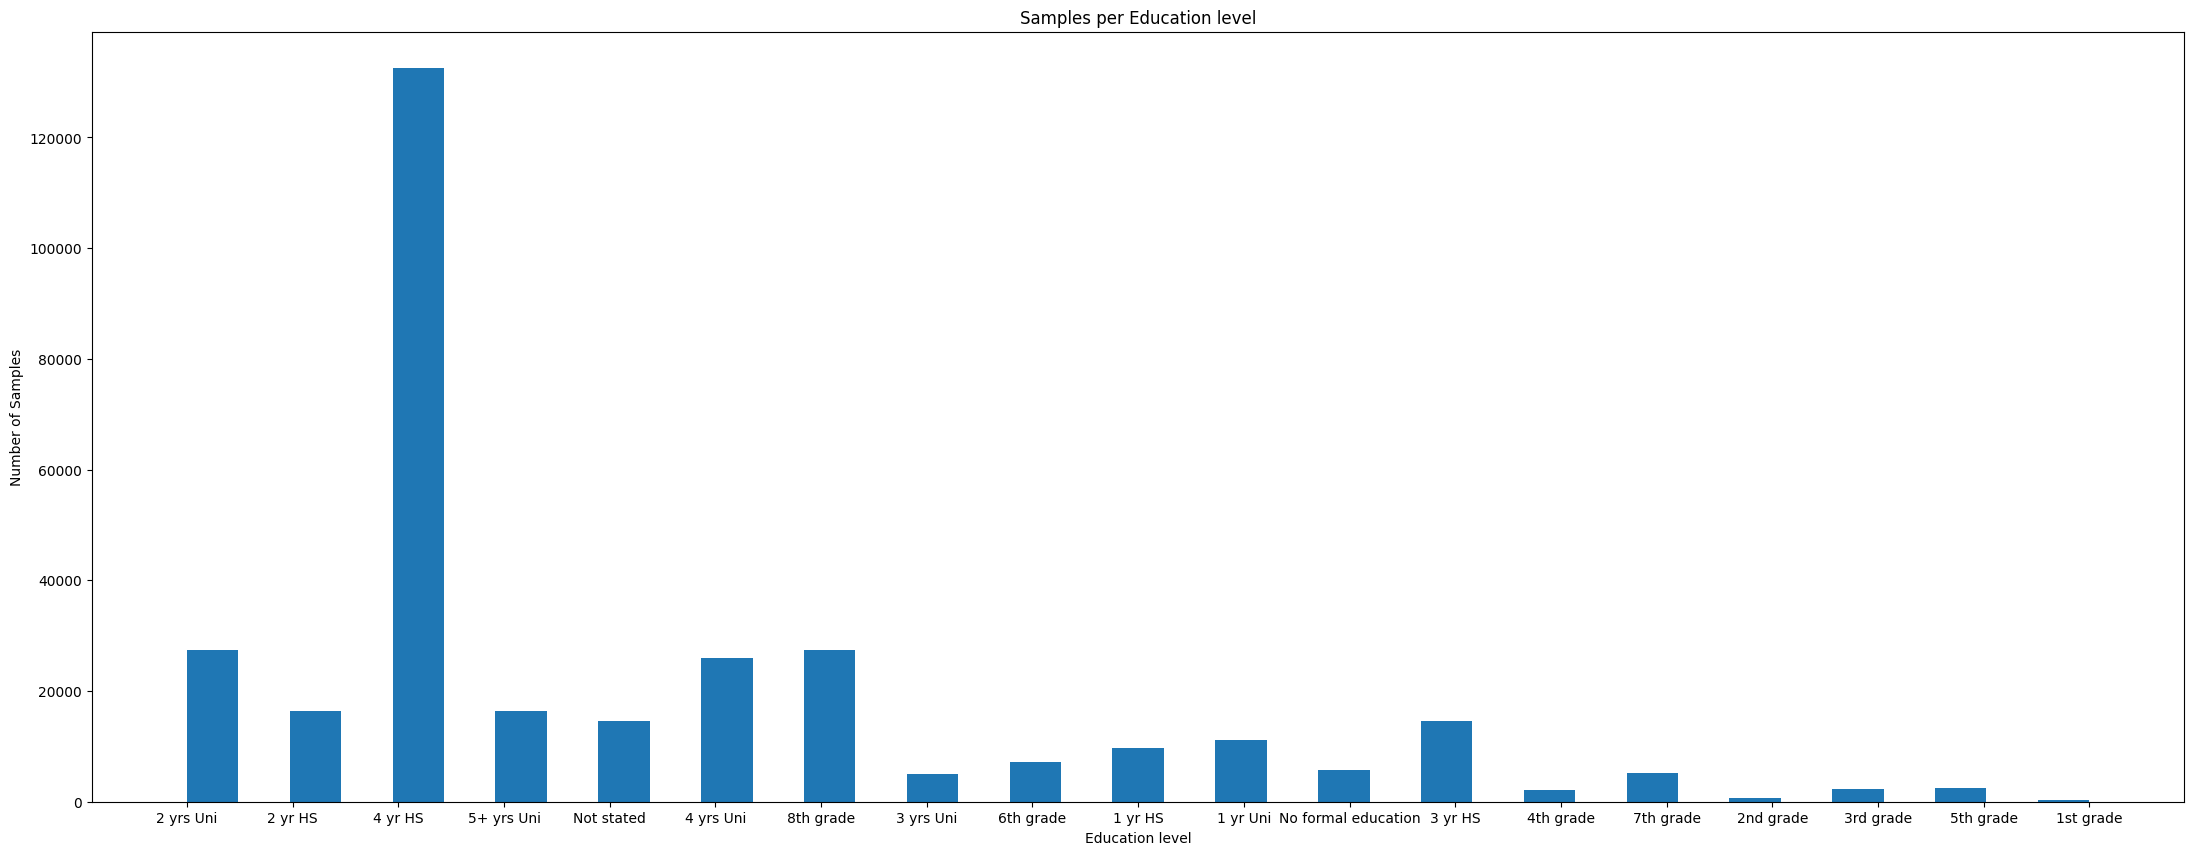

In [217]:
fig = plt.figure(figsize = (27, 10))
plt.title("Samples per Education level")
plt.xlabel("Education level")
plt.ylabel("Number of Samples")
plt.hist(edf['education_1989_revision'], bins = 37)
plt.show()

- Just from looking at the data we can immediately tell that the most common level of education from people deceased between 2005-2015 is 4 years of high school. With a total of 120,000 samples it is around ten times as high as any other level of education.

### Average age of death for each level of education

In [218]:
edff = edf
edff.groupby('education_1989_revision')['detail_age'].mean().sort_values(ascending = False)

education_1989_revision
8th grade              81.165706
4th grade              79.236390
5th grade              79.031541
6th grade              78.985391
3rd grade              78.767187
7th grade              78.168441
5+ yrs Uni             74.490166
4 yrs Uni              73.531114
2nd grade              72.974462
4 yr HS                72.605968
1 yr HS                72.057425
2 yr HS                71.866683
2 yrs Uni              71.118045
Not stated             70.805286
3 yrs Uni              70.641640
3 yr HS                70.513323
1 yr Uni               70.063664
1st grade              61.031546
No formal education    25.514524
Name: detail_age, dtype: float64

- Above we have a list of average age of death for each level of education. 
- From a preliminary viewing we can observe that people with only an 8th grade level of education have the highest life expectancy while those with no formal education have an extremely low life expectancy of about 26 years. I hypothesize that those with no formal education could come from extremley poor backgrounds or bad life circumstances. They could also be people with special needs or who were not able to assimilate to classroom as well as a combination of all of these.
- I am interested to see what other information I can get from those with no formal education


#### Age of death in the US without a formal education

In [219]:
edff = edf.set_index('education_1989_revision')
NFed = edff.loc['No formal education']
new_NFed = NFed[NFed['detail_age'] < 150] #I had a crazy outlier that could not have been physically possible (999 years old)
new_NFed.head(3)

,marital_status,place_of_death_and_decedents_status,358_cause_recode,39_cause_recode,detail_age,age_recode_27,day_of_week_of_death,manner_of_death,Year
education_1989_revision,,,,,,,,,
No formal education,Widowed,Decedent’s home,Other ill-defined and unknown causes of mortality (R96-R99),"Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (excluding Sudden infant death syndrome) (R00-R94,R96-R99)",95.0,95 - 99 years,Thur,Natural,2005
No formal education,"Never married, single","Hospital, Clinic or Medical Center",Anencephaly and similar malformations (Q00),"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",3.0,0 -1 month,Sun,Natural,2005
No formal education,"Never married, single",Decedent’s home,Anencephaly and similar malformations (Q00),"Congenital malformations, deformations and chromosomal abnormalities (Q00-Q99)",2.0,0 -1 month,Wed,Natural,2005


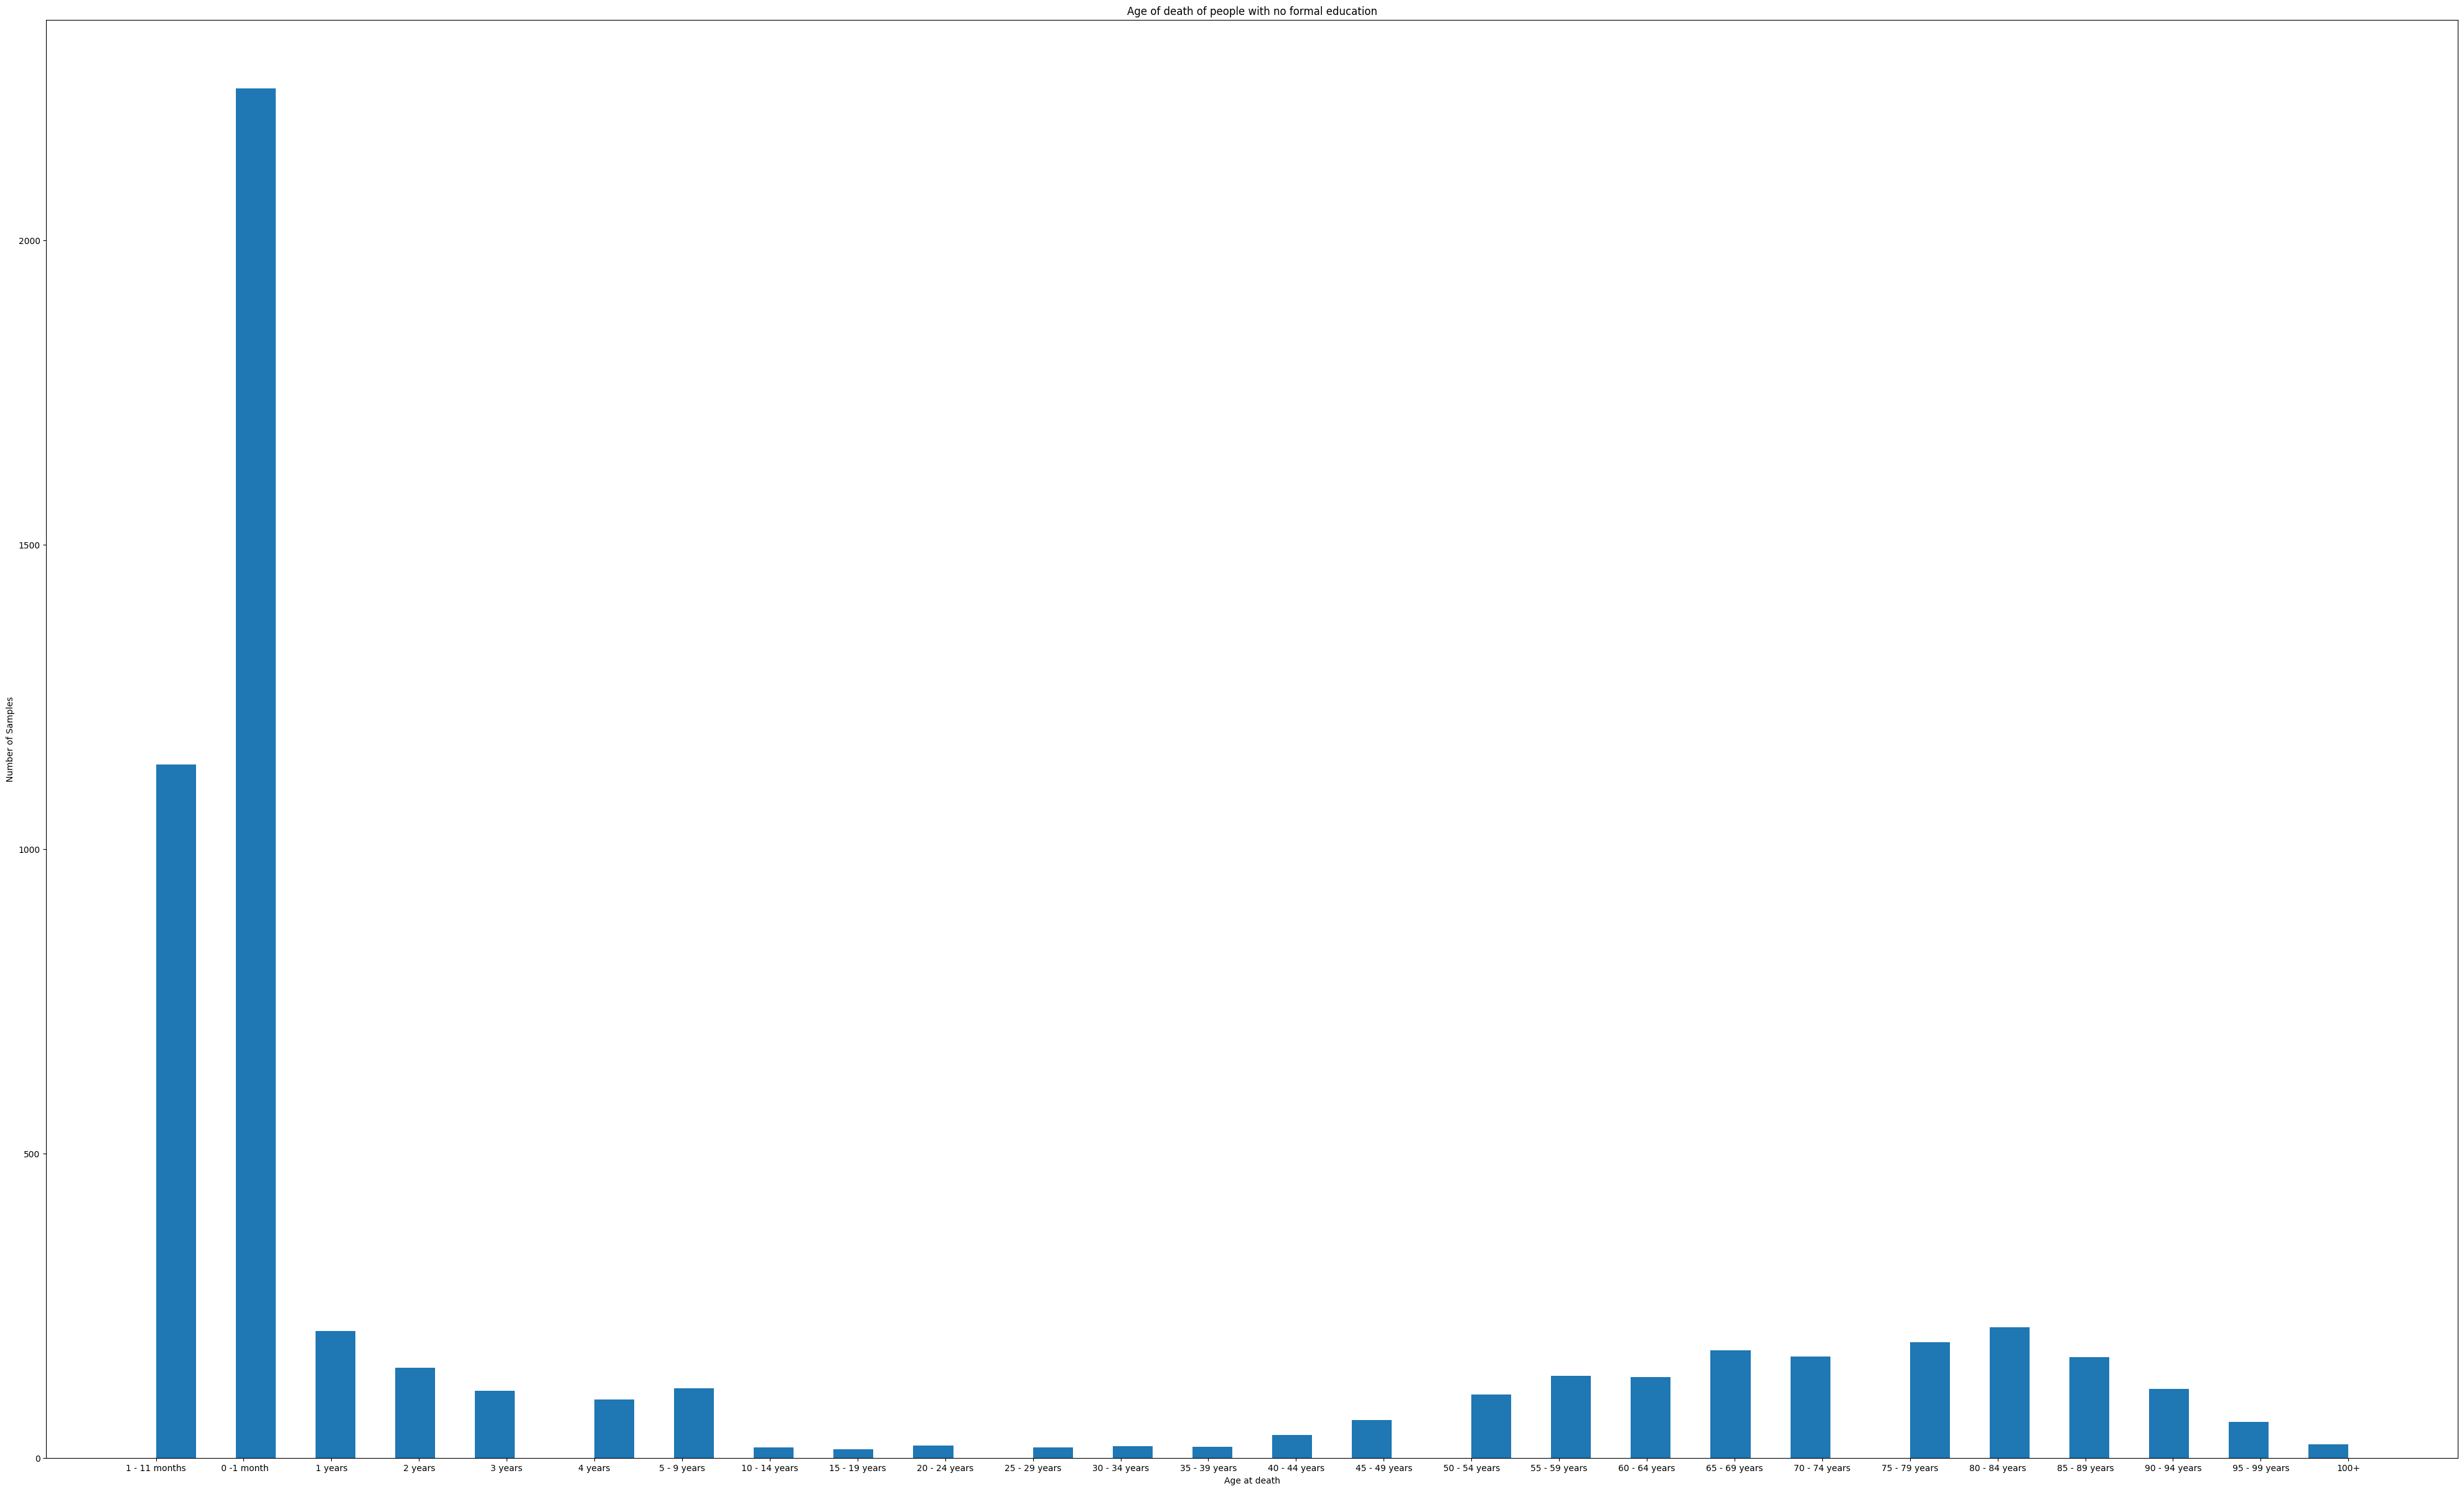

In [220]:
a = NFed.sort_values('detail_age')
fig = plt.figure(figsize = (50, 30))
plt.title("Age of death of people with no formal education")
plt.xlabel("Age at death")
plt.ylabel("Number of Samples")
plt.hist(a['age_recode_27'], bins = 55)
plt.show()

- It appears that most deaths with no formal education occured in newborns and toddlers.
- The death pattern seems to follow a normal distribution after 4 years of age. With young adults and middle-aged people dying at lower rates than those above 50 years of age. This might be related to formal education beginning at ages 5-6
- My original hypothesis is alreayd proven wrong, with most deaths being at 0-1 month old followed by 1-11 months old. 

#### Recategorizing education level

- The spread of samples is very wide, and not equivalent. For my data analysis I want to group education into fewer categories.
- These categories will be: Not available, No formal education, Elementary schooling, Middle Schooling (6th-8th), Some high school, 4 years of high school, Some college (1-3 years), 4 years of college, 5+ years of college. 
- This will allow me to get a more generalized view of the data that is easier to comprehend and might give us more information
- However, we will be losing information on the specifics of what schooling year was ended

In [221]:
#Creating a new dictionary
newedudict = dict({"No formal education":"No formal education", "1st grade":"Elementary School","2nd grade":"Elementary School", "3rd grade":"Elementary School", "4th grade":"Elementary School", 
                         "5th grade":"Elementary School", "6th grade":"Middle School", "7th grade":"Middle School", "8th grade":"Middle School",
                         "1 yr HS":"Some High School", "2 yr HS":"Some High School", "3 yr HS":"Some High School", "4 yr HS":"4 yr HS", "1 yr Uni":"Some College", 
                         "2 yrs Uni":"Some College", "3 yrs Uni":"Some College", "4 yrs Uni":"4 yrs Uni", "5+ yrs Uni":"5+ yrs Uni", "Not stated":"Not stated"})

In [222]:
#modifying our new dataframe
edf['education_1989_revision'] = edf['education_1989_revision'].replace(newedudict)


<ipython-input-222-15511fccfe00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['education_1989_revision'] = edf['education_1989_revision'].replace(newedudict)


In [223]:
edf.head(3) #Header

,education_1989_revision,marital_status,place_of_death_and_decedents_status,358_cause_recode,39_cause_recode,detail_age,age_recode_27,day_of_week_of_death,manner_of_death,Year
7,Some College,Married,"Hospital, Clinic or Medical Center",Renal failure (N17-N19),"Nephritis, nephrotic syndrome, and nephrosis (N00-N07,N17-N19,N25-N27)",81.0,80 - 84 years,Tue,Natural,2005
8,Some High School,Married,"Hospital, Clinic or Medical Center",Septicemia (A40-A41),"All other diseases (Residual) (A00-A09,A20-A49,A54-B19,B25-B99,D00-E07, E15-G25,G31-H93,I80-J06,J20-J39,J60-K22,K29-K66,K71-K72, K75-M99,N10-N15,N20-N23,N28-N98)",70.0,70 - 74 years,Sun,Natural,2005
9,4 yr HS,"Never married, single",Nursing home/long term care,Alzheimer=s disease (G30),Alzheimer's disease (G30),87.0,85 - 89 years,Fri,Natural,2005


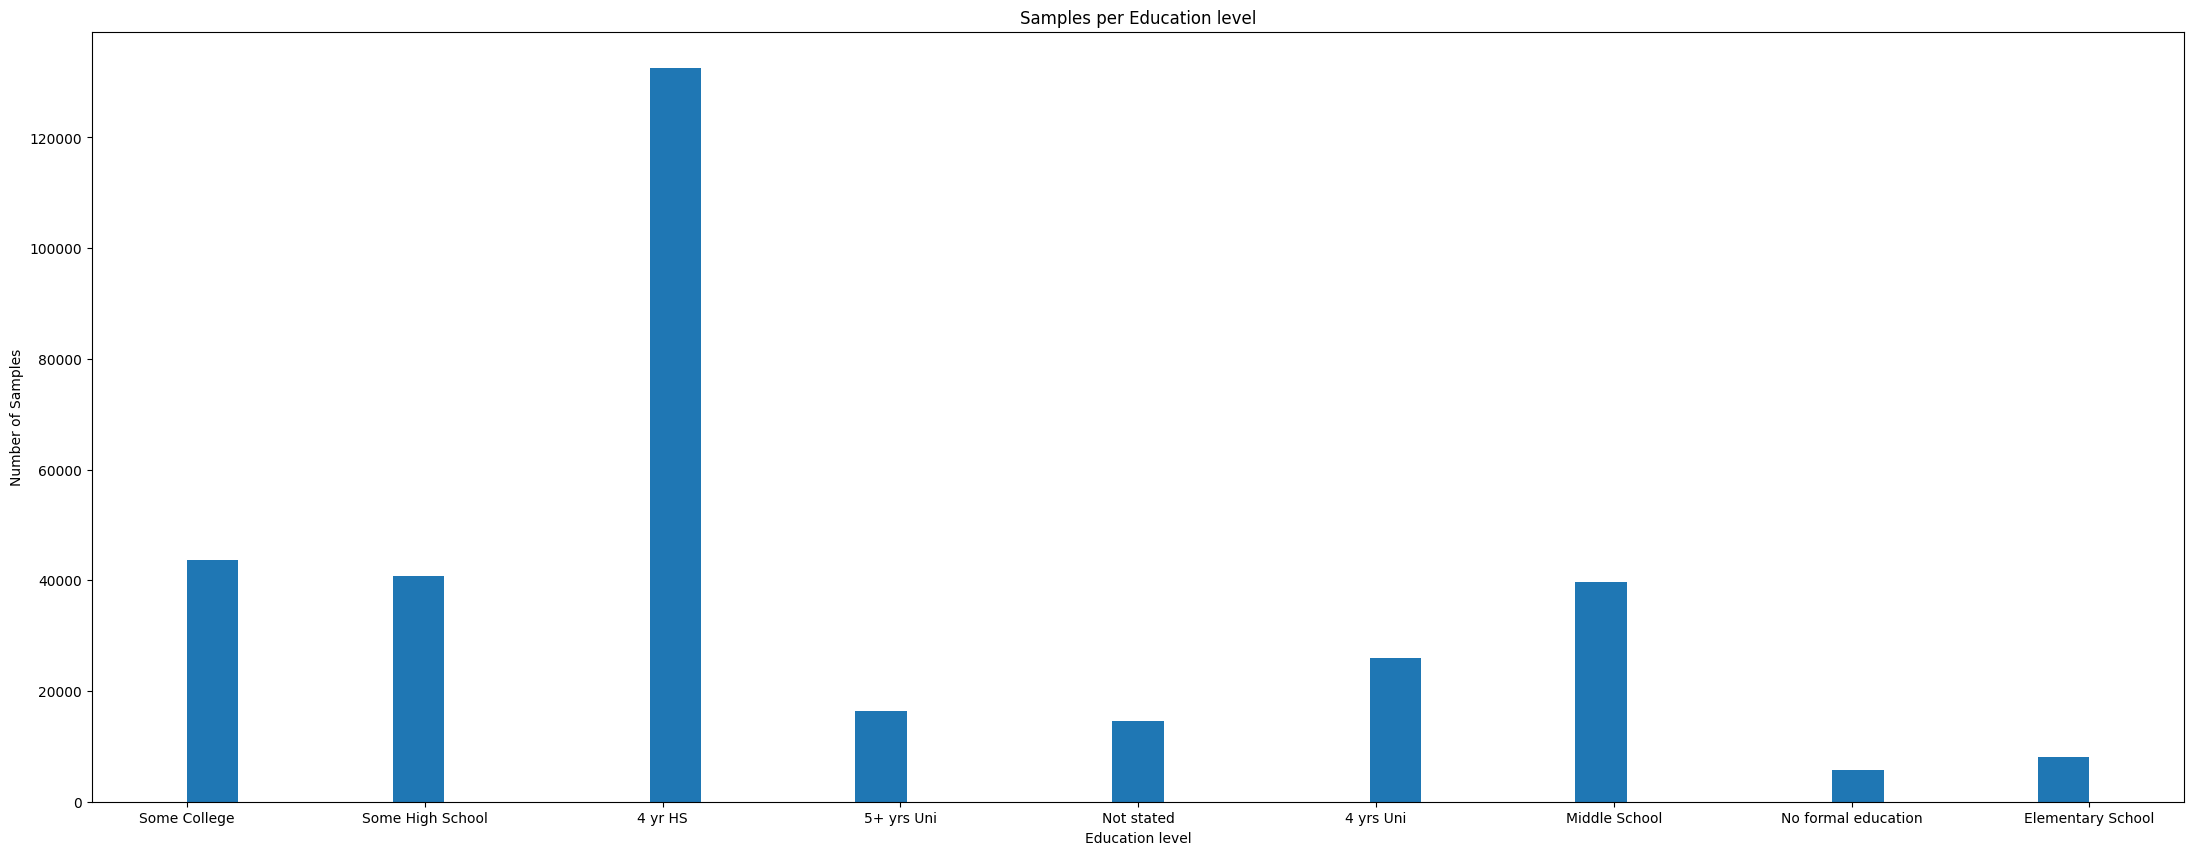

In [224]:
fig = plt.figure(figsize = (27, 10)) #plotting it!
plt.title("Samples per Education level")
plt.xlabel("Education level")
plt.ylabel("Number of Samples")
plt.hist(edf['education_1989_revision'], bins = 37)
plt.show()

#### Does recategorizing the data affect the average age of death at all?

In [225]:
edf.groupby('education_1989_revision')['detail_age'].mean().sort_values(ascending = False)

education_1989_revision
Middle School          80.379257
Elementary School      77.730091
5+ yrs Uni             74.490166
4 yrs Uni              73.531114
4 yr HS                72.605968
Some High School       71.427077
Not stated             70.805286
Some College           70.793659
No formal education    25.514524
Name: detail_age, dtype: float64

- Not by much. Although it did bring 6th and 7th grade up by two years and 8th grade down by 1 year. 


- So overall from this dataset it seems that finishing up your education in middle school increases your longevity. Any more education after that will only decrease it. (Although the dataset is unbalanced)

#### Investigating the longevity of those with only a middle school education

- An interesting question to explore would be, why people with lower levels of education live longer than those with a higher level of education. The differences between people who only accomplished a middle school education versus those who finished 4 years of university is a whopping 5 years on average. 6 year difference for those who only finished high school. 

- Let's plot it and see if how the data is distributed

In [226]:
#new dataset with only middle school education level
middf = edf.set_index('education_1989_revision').loc['Middle School']

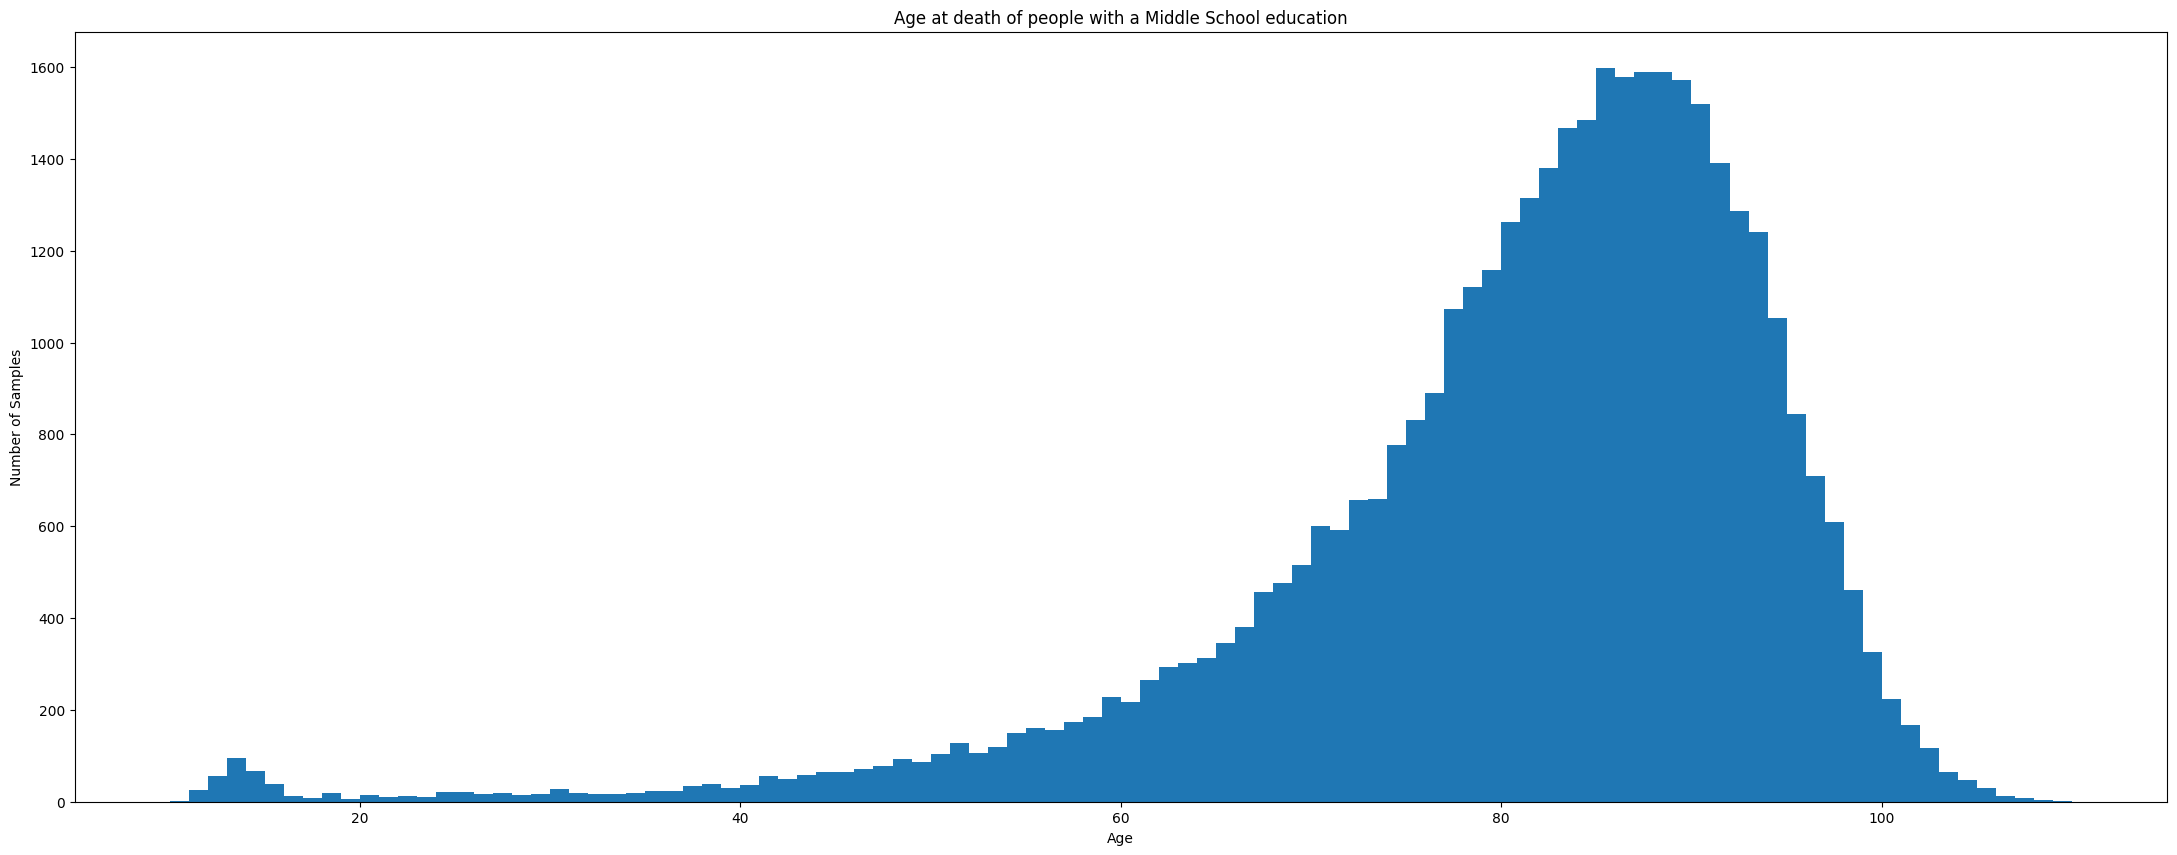

In [227]:
fig = plt.figure(figsize = (27, 10)) #plotting it!
plt.title("Age at death of people with a Middle School education")
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.hist(middf['detail_age'], bins = 100)
plt.show()

- As we can see the vast majority of those with only a middle school education live past the age of 70.
- There are a lack of outliers on the older end of the spectrum. Which further demonstrates the longevity of those with a middle school education
- For a comparison I will compare this graph to people with a high school and college education

In [228]:
#new dataset with different educational levels
somecoldf = edf.set_index('education_1989_revision').loc['Some College']
col4df = edf.set_index('education_1989_revision').loc['4 yrs Uni']
highdf = edf.set_index('education_1989_revision').loc['4 yr HS']

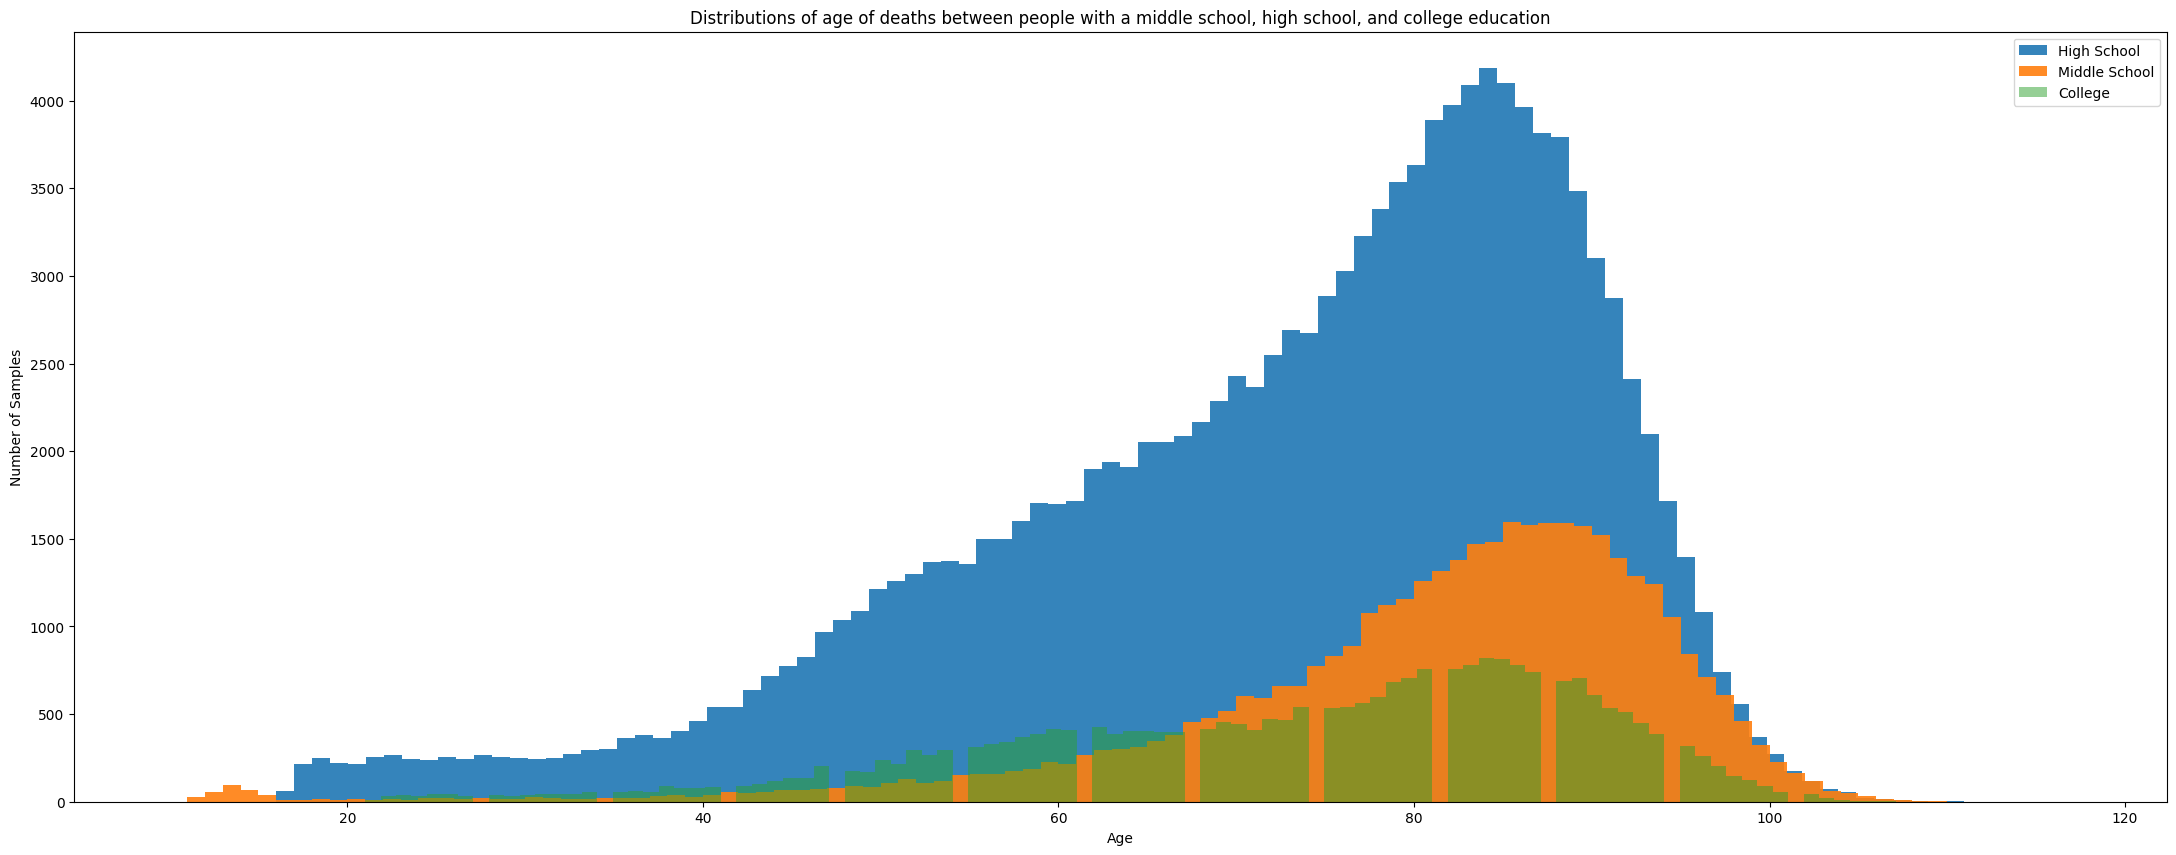

In [229]:
#Plotting the dataset 
fig = plt.figure(figsize = (27, 10)) #plotting it!
plt.title("Distributions of age of deaths between people with a middle school, high school, and college education")
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.hist(highdf['detail_age'], alpha = 0.9, bins = 100, label = 'High School' )
plt.hist(middf['detail_age'], alpha = 0.9, bins = 100, label = "Middle School" )
plt.hist(col4df['detail_age'], alpha = 0.5, bins = 100, label = "College")
plt.legend()
plt.show()

- From this graph we are easily able to tell the sample differences between these 3 educational levels
- All graphs are left skewed, which makes sense because most people die after the age of 60. 
- But what is interesting in this graph is how few samples (comparatively) the middle school education group has before the age of 70.
- Both high school education and college education groups have a much higher percentage of samples below the age of 70. They also both peak earlier than the middle school education group
- The peak for the middle school education group is larger than both other groups. It stays consistent at a peak of around 1500 samples between 85-90. 
- The other groups only had peaks lasting one or two years. 
- It is very interesting that the middle school group has such longevity compared to high school education or even college educated people.
- Although the sample sizes are not equal it is representative of education levels of adults-seniors around that time. From this we can surmise that those with a middle school education consistently lived the longest between 2005-2015.  
- While those with a 4 year college education lived on average 1 more year than people who graduated with a high school degree. 
- College educated people also have a higher chance of dying at any age, than those with a high school or middle school education

- Unfortunately this dataset does not indicate lifestyle choices, but in the next phase of this section we will see whether there are any differences in the cause of death which might give us some more information

### Cause of death

- Let's see what the top cause of death is for each education level and go from there

In [230]:
#Creating a function so I only get one top value for each education level
pd.set_option('display.max_colwidth', None)
def top_val(x): #function to defined the top value for each aggregate
    return x.value_counts().index[0]

In [231]:
edf.groupby('education_1989_revision')['358_cause_recode'].agg(top_val)

education_1989_revision
4 yr HS                                      All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
4 yrs Uni                                    All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
5+ yrs Uni                                   All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
Elementary School                            All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
Middle School                                All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
No formal education    Disorders related to short gestation and low birth weight, not elsewhere classified (P07)
Not stated                                   All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
Some College                                 All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)
Some High School                             All other forms of chronic 

- It seems by far that the top cause of death among every education level besides those with no formal education is unspecified chronic ischemic heart disease
- The only group that does not have heart disease as its main cause of death, is the group with no formal education. The main cause of death within the no formal eduation group are disorders related to short gestation and low birth weight, which makes sense according to our earlier investigation. Most people in the no formal education group died before 1 month or between 1-11 months. 
- What changes if I gather the top 5 causes of death for education level?

In [232]:
#Creating a very inefficient method of getting the dataframe I want. 
#Getting the top 5 diseases from each. 
#I attempted multiple different ways of doing this but this was the best looking
#although was the most code intensive. 
def t1(x):
  one = x.value_counts().index[0]
  return one
def t2(x):
  one = x.value_counts().index[1]
  return one
def t3(x):
  one = x.value_counts().index[2]
  return one
def t4(x):
  one = x.value_counts().index[3]
  return one
def t5(x):
  one = x.value_counts().index[4]
  return one

In [233]:
a = edf.groupby('education_1989_revision')['358_cause_recode'].agg(t1)
b = edf.groupby('education_1989_revision')['358_cause_recode'].agg(t2)
c = edf.groupby('education_1989_revision')['358_cause_recode'].agg(t3)
d = edf.groupby('education_1989_revision')['358_cause_recode'].agg(t4)
e = edf.groupby('education_1989_revision')['358_cause_recode'].agg(t5)
dflist = [a,b,c,d,e]
pd.concat([pd.DataFrame(a), pd.DataFrame(b), pd.DataFrame(c), pd.DataFrame(d), pd.DataFrame(e)], axis = 1)

,358_cause_recode,358_cause_recode,358_cause_recode,358_cause_recode,358_cause_recode
education_1989_revision,,,,,
4 yr HS,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Acute myocardial infarction (I21-I22),Other chronic obstructive pulmonary disease (J44),"Organic dementia (F01,F03)"
4 yrs Uni,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Acute myocardial infarction (I21-I22),"Organic dementia (F01,F03)",Alzheimer=s disease (G30)
5+ yrs Uni,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Acute myocardial infarction (I21-I22),"Organic dementia (F01,F03)",Alzheimer=s disease (G30)
Elementary School,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Acute myocardial infarction (I21-I22),Other chronic obstructive pulmonary disease (J44),"Of trachea, bronchus and lung (C33-C34)","Organic dementia (F01,F03)"
Middle School,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Acute myocardial infarction (I21-I22),"Of trachea, bronchus and lung (C33-C34)",Other chronic obstructive pulmonary disease (J44),"Organic dementia (F01,F03)"
No formal education,"Disorders related to short gestation and low birth weight, not elsewhere classified (P07)","Newborn affected by maternal factors and by complications of pregnancy, labor and delivery (P00-P04)",Sudden infant death syndrome (R95),"Other and unspecified conditions originating in the perinatal period (P05,P08,P29,P50-P96)","Other congenital malformations and deformations (Q10-Q18,Q35-Q89)"
Not stated,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Acute myocardial infarction (I21-I22),Other chronic obstructive pulmonary disease (J44),"Organic dementia (F01,F03)"
Some College,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Acute myocardial infarction (I21-I22),Other chronic obstructive pulmonary disease (J44),"Organic dementia (F01,F03)"
Some High School,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Of trachea, bronchus and lung (C33-C34)",Other chronic obstructive pulmonary disease (J44),Acute myocardial infarction (I21-I22),"Organic dementia (F01,F03)"


- The most common cause of death for all education levels except Not formally educated people was some form of heart disease followed by diseases of trachea, bronchus, or lung or alternatively an acute myocardial infarction (heart attack). Dementia was consistently in the top 5 for all of them (except Not formally educated people). 


- From a preliminary view of the data it seems that Americans of all education levels are dying of the same 5 things: Heart disease, Lung, trachea, or bronchus issues (all classified under one), Heart attacks, other pulmonary diseases, or Organic dementia. 


- People who completed four or more years of college are more likely to die of Alzheimer's and organic dementia instead of dying of pulmonary diseases. 


- In terms of people with no formal education, most are infants or toddlers so the diseases are rightly associated with that. Short gestation and low birth weight are the top reason infants die in the US according to this dataset. This is followed by pregnancy complications, sudden infant death syndrome, other conditions during the perinatal period, and lastly congenital malformations and deformations. 

#### Are there any causes of death that are solely related to one education group?

In [234]:
# I need to write a function that goes through the middle 5-15 causes of death for each education level and then 
#takes the raw number of counts for that cause of death and then divides it by the total number of samples in that
#education level which will gives us a percent. These percentages should then be printed out along with each disease
newedf = edf.loc[:, ['education_1989_revision', '358_cause_recode']]


In [235]:
#Making a function to find the percentage of each disease for each education level
def value_counting(column, num, df):
    q = df.loc[column].value_counts()[:num]
    z = df.loc[column].shape[0]
    return q/z*100
'''
def value_counts_1(column): #I'll have to update a dictionary with the percentages
    q = a.loc[column].value_counts()[:15]
    z = a.loc[column].shape[0]
    return q/z*100
'''

"\ndef value_counts_1(column): #I'll have to update a dictionary with the percentages\n    q = a.loc[column].value_counts()[:15]\n    z = a.loc[column].shape[0]\n    return q/z*100\n"

- The percentage is the amount of deaths related to a cause divided by that datasets sample size

In [236]:
top15 = newedf.set_index('education_1989_revision')
edulist = ['Elementary School', 'Middle School', 'Some High School',
           '4 yr HS','Some College', '4 yrs Uni', '5+ yrs Uni',
           'No formal education', 'Not stated']

t15 = pd.DataFrame()

for i in edulist:
    t15[i] = value_counting(i, 15, top15)
t15

,Elementary School,Middle School,Some High School,4 yr HS,Some College,4 yrs Uni,5+ yrs Uni,No formal education,Not stated
358_cause_recode,,,,,,,,,
"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",7.988499,8.503632,7.572186,7.317110,6.803312,6.863919,6.683258,1.582884,6.945772
Acute myocardial infarction (I21-I22),6.350794,6.314255,5.647221,5.595393,5.099053,5.175943,4.947190,1.687250,5.197377
Other chronic obstructive pulmonary disease (J44),5.838230,5.841691,5.860833,4.953806,4.149700,3.248484,2.707296,NaN,4.685152
"Of trachea, bronchus and lung (C33-C34)",5.363170,6.083000,7.454331,7.132937,6.576840,5.890533,5.020032,NaN,6.269635
"Organic dementia (F01,F03)",5.025628,5.351532,3.707523,3.931796,3.529762,4.179381,4.279471,NaN,3.428493
Diabetes mellitus (E10-E14),3.850481,3.300405,2.860440,2.785997,2.708514,2.352350,2.215612,NaN,2.854801
Alzheimer=s disease (G30),3.750469,4.072091,2.887448,2.886386,3.088255,3.337325,3.332524,NaN,3.032373
"Stroke, not specified as hemorrhage or infarction (I64)",3.337917,3.906191,2.990572,2.890160,2.692501,2.873807,2.701226,NaN,2.909439
Congestive heart failure (I50.0),3.175397,3.353191,2.548615,2.351982,1.992497,2.004712,2.003156,NaN,2.492829


- The distribution of the top 5 diseases seems pretty even between all education levels discounting no formal education. The middle school education group had the highest percentage of the cause of death being ischemic heart disease at 8.5%. People who had gone to university for more than 5 years had 2 percentage points less chance of dying from chronic ischemic heart disease.


- For many of the diseases that affect those who only graduate from elementary and middle school, it affects those who ent to 5+ years of university less. But only by a few percentage points. However, these could really add up. 

- An interesting note is that even though Alzheimer's did not make the top 5 in most Middle School or elementary school education groups it still had a higher percentage of deaths associated with it, compared to groups who had it higher on the list (4 years of college or 5+ years of college)

#### Can we tell anything from more samples?

In [237]:
edulist2 = ['Elementary School', 'Middle School', '5+ yrs Uni']
edulist2df = pd.DataFrame()
#place_of_death_and_decedents_status
for i in edulist:
    edulist2df[i] = value_counting(i, 25, top15)
edulist2df#['Elementary School']

,Elementary School,Middle School,Some High School,4 yr HS,Some College,4 yrs Uni,5+ yrs Uni,No formal education,Not stated
358_cause_recode,,,,,,,,,
"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",7.988499,8.503632,7.572186,7.317110,6.803312,6.863919,6.683258,1.582884,6.945772
Acute myocardial infarction (I21-I22),6.350794,6.314255,5.647221,5.595393,5.099053,5.175943,4.947190,1.687250,5.197377
Other chronic obstructive pulmonary disease (J44),5.838230,5.841691,5.860833,4.953806,4.149700,3.248484,2.707296,NaN,4.685152
"Of trachea, bronchus and lung (C33-C34)",5.363170,6.083000,7.454331,7.132937,6.576840,5.890533,5.020032,NaN,6.269635
"Organic dementia (F01,F03)",5.025628,5.351532,3.707523,3.931796,3.529762,4.179381,4.279471,1.061054,3.428493
Diabetes mellitus (E10-E14),3.850481,3.300405,2.860440,2.785997,2.708514,2.352350,2.215612,NaN,2.854801
Alzheimer=s disease (G30),3.750469,4.072091,2.887448,2.886386,3.088255,3.337325,3.332524,NaN,3.032373
"Stroke, not specified as hemorrhage or infarction (I64)",3.337917,3.906191,2.990572,2.890160,2.692501,2.873807,2.701226,1.026265,2.909439
Congestive heart failure (I50.0),3.175397,3.353191,2.548615,2.351982,1.992497,2.004712,2.003156,NaN,2.492829


- The Nan values come from the columns not having the disease within their top 25 causes of death. 
- For the top 12 causes of death, it seems that people with 5+ years of university score are anywehere from 0.5-2 percentage points less likely to experience it than those with middle school and elementary educations. However, with Atherosclerotic cardiovascular disease those with 5+ years of univeristy score higher, as well as with prostate, malignant neoplasms, colon, pancreas, and intracerebral and other intracranial hemorrhages. 

### Does education level affect where you die?
- I would think so, but our data is not specific enough. 
- To test whether there there is a relationship between any education levels and places I will create a new dataframe.
- Then I will create a histogram to display this information

In [238]:
placedf = edf.loc[:,['education_1989_revision', 'place_of_death_and_decedents_status']]

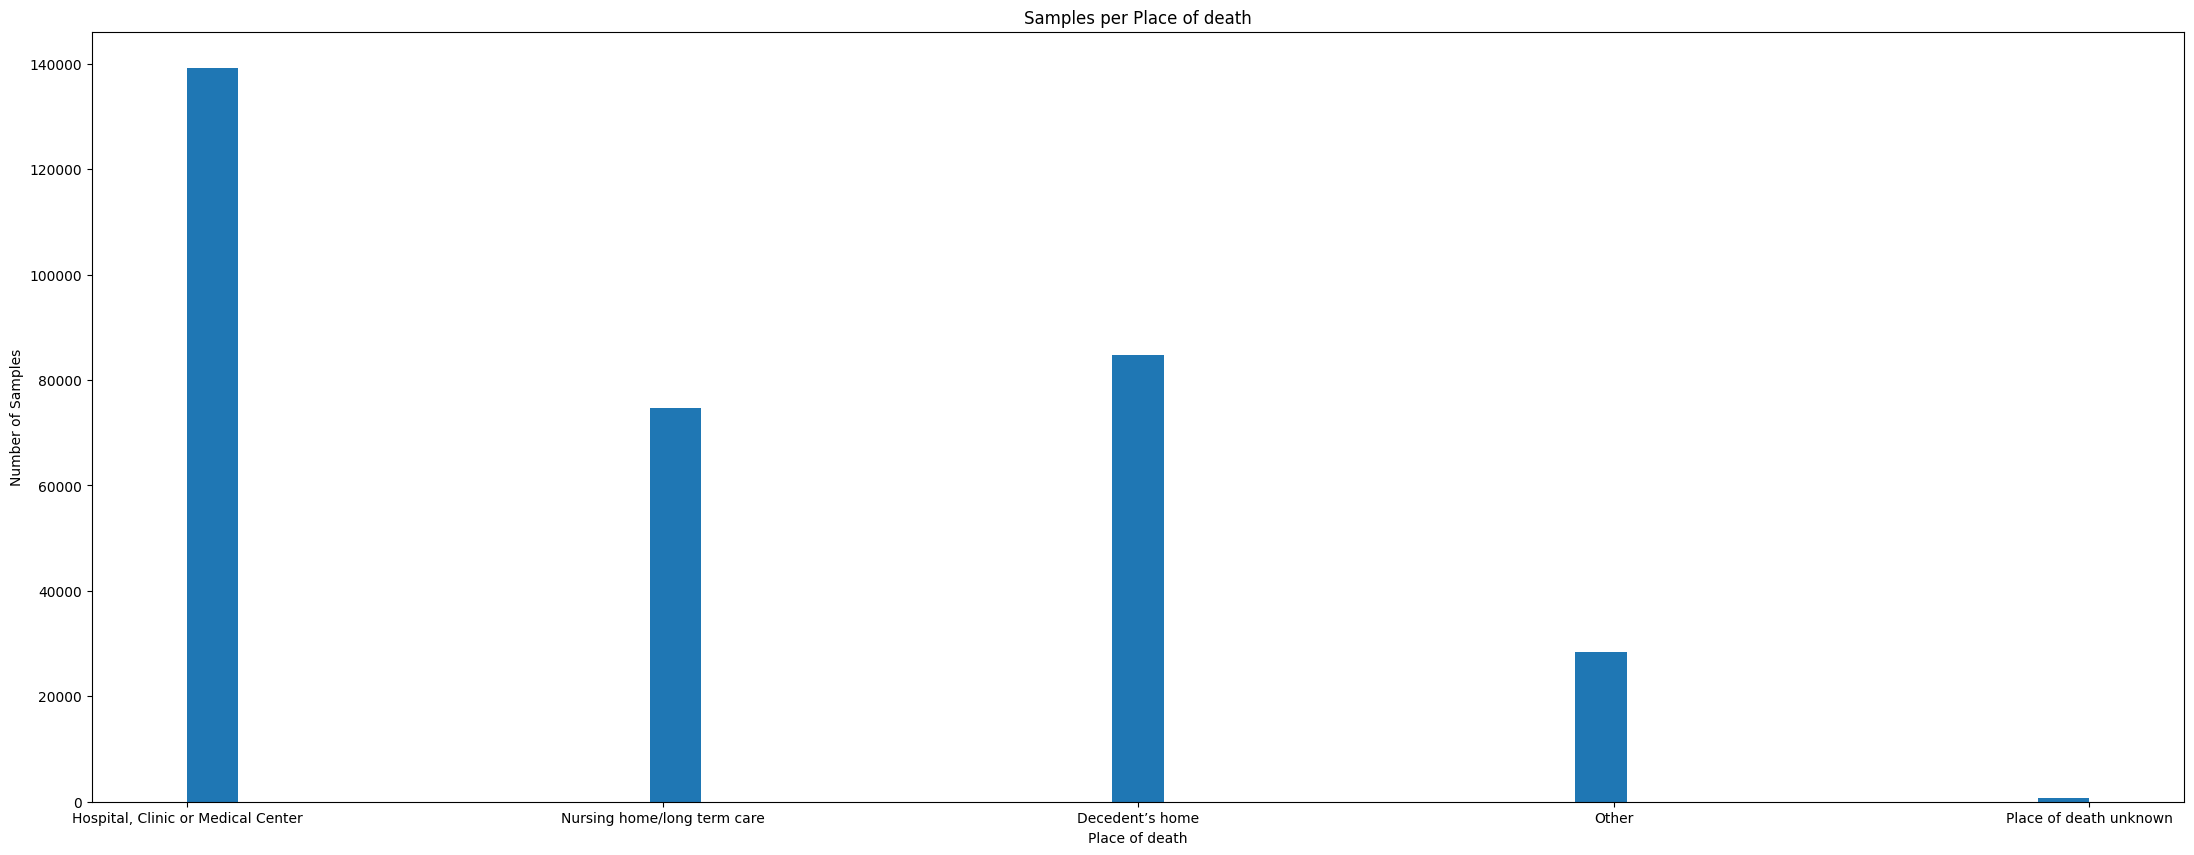

In [239]:
fig = plt.figure(figsize = (27, 10))
plt.title("Samples per Place of death")
plt.xlabel("Place of death")
plt.ylabel("Number of Samples")
plt.hist(placedf['place_of_death_and_decedents_status'], bins = 37)
plt.show()

- A preliminary look at the data shows that most people end up dying in a hospital, clinic, or medical center
- Let's look at percentages then!

In [240]:
edulist = ['Elementary School', 'Middle School', 'Some High School',
           '4 yr HS','Some College', '4 yrs Uni', '5+ yrs Uni',
           'No formal education', 'Not stated']
edulist3df = pd.DataFrame()
#place_of_death_and_decedents_status
for i in edulist:
    edulist3df[i] = value_counting(i, 5, top15)
edulist3df

,Elementary School,Middle School,Some High School,4 yr HS,Some College,4 yrs Uni,5+ yrs Uni,No formal education,Not stated
358_cause_recode,,,,,,,,,
"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",7.988499,8.503632,7.572186,7.317110,6.803312,6.863919,6.683258,NaN,6.945772
Acute myocardial infarction (I21-I22),6.350794,6.314255,5.647221,5.595393,5.099053,5.175943,4.947190,NaN,5.197377
Other chronic obstructive pulmonary disease (J44),5.838230,5.841691,5.860833,4.953806,4.149700,NaN,NaN,NaN,4.685152
"Of trachea, bronchus and lung (C33-C34)",5.363170,6.083000,7.454331,7.132937,6.576840,5.890533,5.020032,NaN,6.269635
"Organic dementia (F01,F03)",5.025628,5.351532,3.707523,3.931796,3.529762,4.179381,4.279471,NaN,3.428493


- From this preliminary data we have found that most people regardless of education level died in the hospital, clinic, or the medical center. 
- Although those who went to university for 4 or more years have greater chance of dying in their home
- Those with a middle school education are almost 10 percentage points more likely to die in a nursing home or long term care than those who went to college at all. 

# Marital Status, sex, and race

### Taking a look at the data spread

#### Selecting pertinent data

In [241]:
marital_df = fulldf.loc[:,['marital_status', 'race', '358_cause_recode','sex','detail_age','Year']]
marital_df = marital_df[marital_df['detail_age'] > 17] #I only care about people 
#who were of age to be married, and a lot of infant and child deaths would skew that


In [242]:
marital_df['marital_status'].unique()

array(['Married', 'Never married, single', 'Widowed', 'Divorced',
       'Marital Status unknown'], dtype=object)

#### Samples per marital status graph

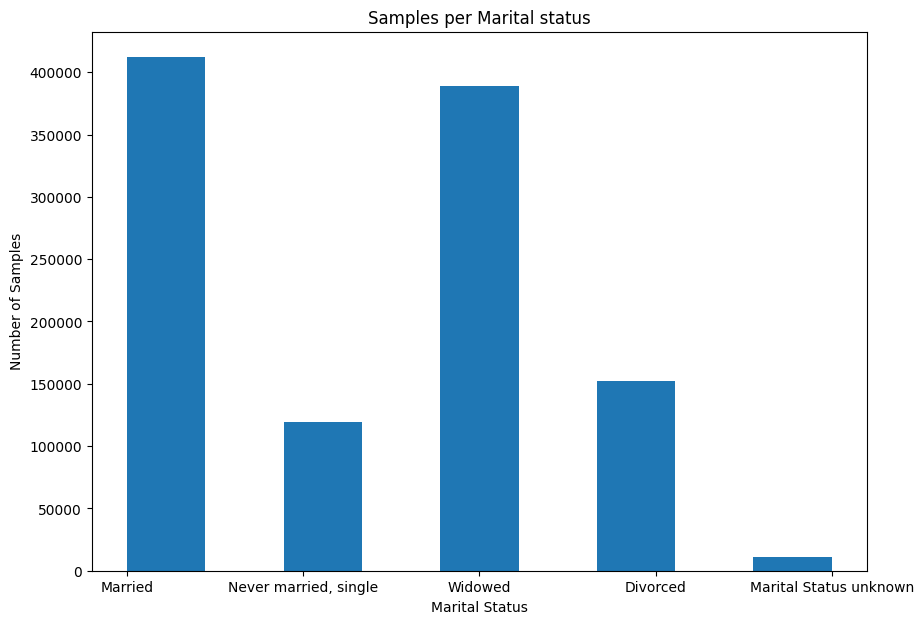

In [243]:
fig = plt.figure(figsize = (10, 7))
plt.title("Samples per Marital status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Samples")
plt.hist(marital_df['marital_status'], bins = 9)
plt.show()

- Most of our samples come from married or widowed people which are almost 4 times as big as the categories never married, or divorced

- Before we investigate the data there are a few things to keep in mind. We are only interested in adults 18 and up who are legally allowed to get married. There are situations where people marry before the age of 18 but the vast majority of people get married after 18. There is some data loss from this but it was more benefical to remove any people with less than 18 years of age because infant and child deaths would vastly skew the data. 

- Another piece of information to keep in mind is that the age of widows and widowers at death will on average be much higher than those who were married because they outlived their spouses. Their spouses died and were placed in the married category while widows and widowers, even if by a little bit, outlived their partner. On scales the size of 400,000 samples this will add up to be quite a bit and it needs to be expected when dealing with the data

### Average age of death for each marital status 

In [244]:
marital_df.groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   84.795244
Married                   71.485636
Marital Status unknown    67.305275
Divorced                  66.831149
Never married, single     56.362075
Name: detail_age, dtype: float64

#### Average age of death per sex

In [245]:
marital_df.groupby('sex')['detail_age'].mean().sort_values(ascending = False)

sex
F    77.277209
M    70.511086
Name: detail_age, dtype: float64

- Women on average outlived men by 7 years!

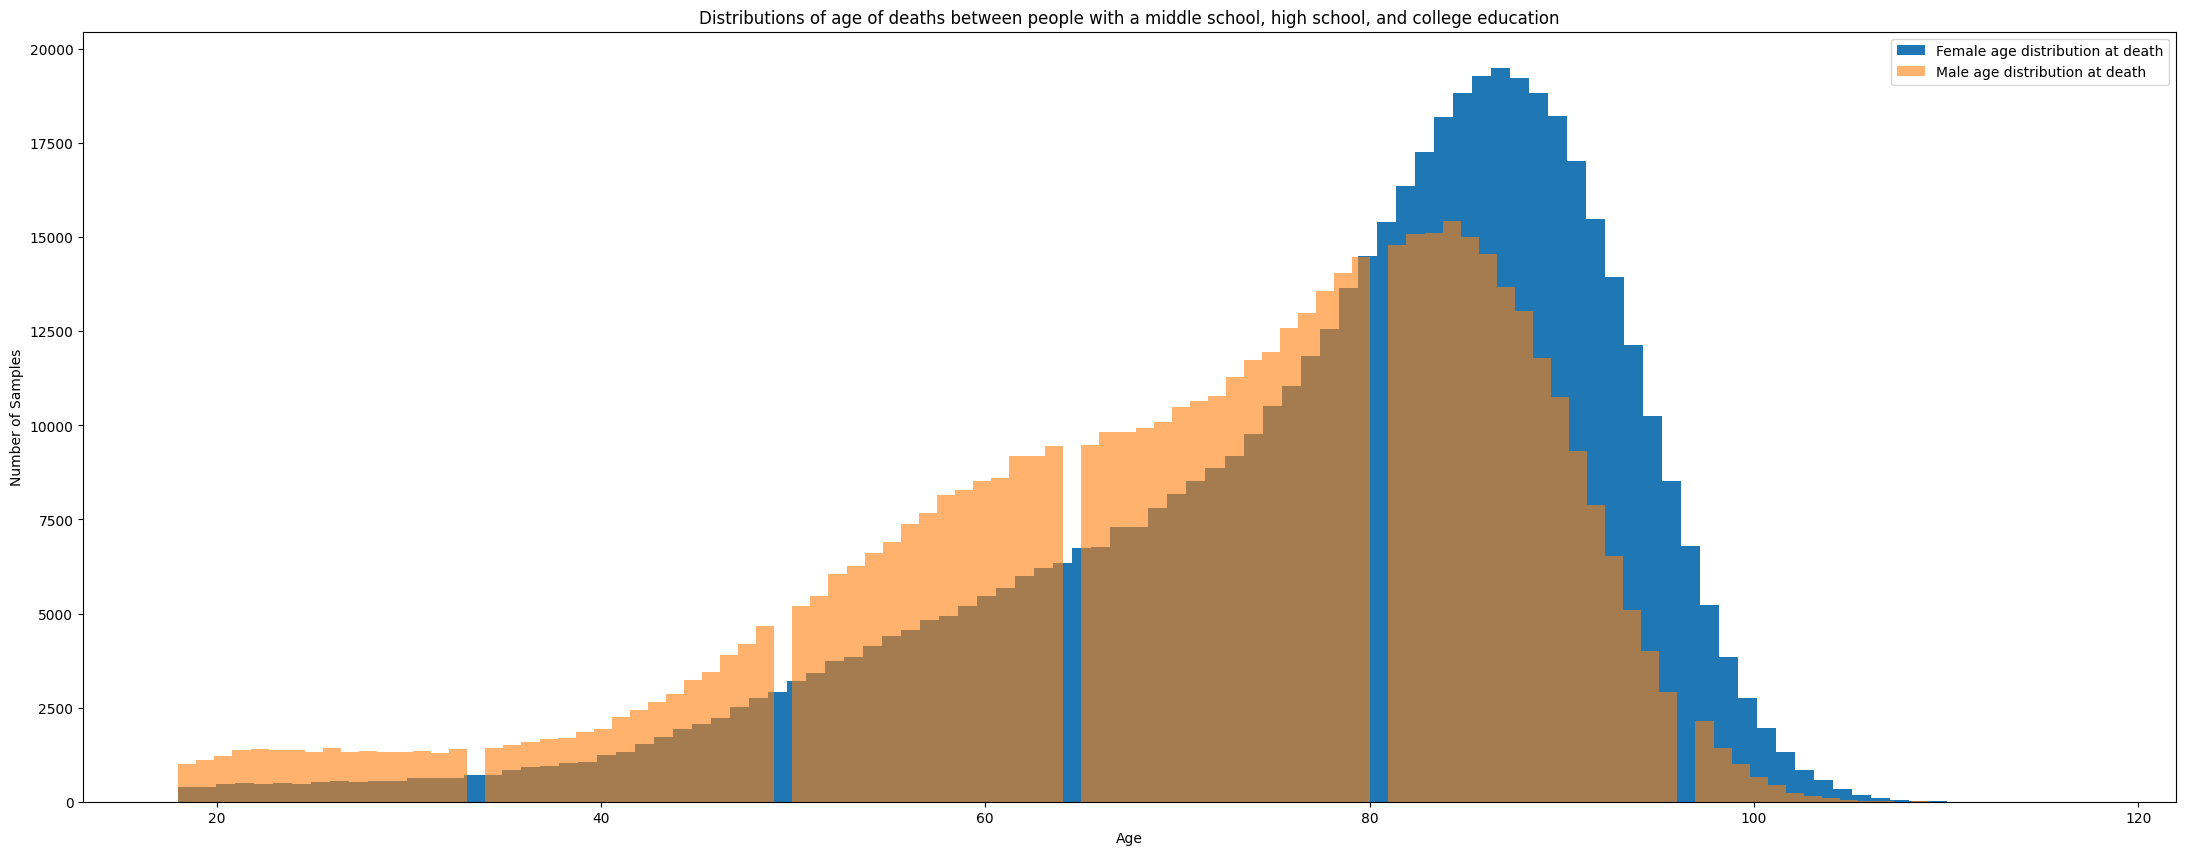

In [246]:
Maledf = marital_df.set_index('sex').loc['M']
Femaledf = marital_df.set_index('sex').loc['F']
fig = plt.figure(figsize = (27, 10)) #plotting it!
plt.title("Distributions of age of deaths between people with a middle school, high school, and college education")
plt.xlabel("Age")
plt.ylabel("Number of Samples")
plt.hist(Femaledf['detail_age'], alpha = 1.0, bins = 100, label = "Female age distribution at death" )
plt.hist(Maledf['detail_age'], alpha = 0.6, bins = 100, label = 'Male age distribution at death' )
plt.legend()
plt.show()

- From this visualization we can see that men die off between 20-79 at much higher rates than women. While women have a much more left-skewed graph, where the majority of deaths are after 80 years of age. 

#### How do men and women differ in longevity according to marital status?

In [247]:
#Seperating the men and women into different datasets
Maledf = marital_df.set_index('sex').loc['M']
Femaledf = marital_df.set_index('sex').loc['F']

In [248]:
Maledf.groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   83.518019
Married                   72.523333
Marital Status unknown    64.519081
Divorced                  64.426330
Never married, single     52.198767
Name: detail_age, dtype: float64

In [249]:
Femaledf.groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   85.246404
Marital Status unknown    71.826427
Divorced                  69.608292
Married                   69.357268
Never married, single     62.991358
Name: detail_age, dtype: float64

- Firstly what we can tell from the data is that widowed men and women live to comparable ages. 83 years and 85 years for women respectively. Married men tend to live longer by 3 or so years than married women. 
- From this data we can see that being divorced or married has little to no effect on how long the average woman lives. However, married men have an almost 10 year difference between divorced men. 
- Never married, single women also lived 10 to almost 11 years longer than men who were never married

- It seems that marriage is very beneficial for men while it is almost negative for women unless their spouse died. 

### Does marital status affect the likelihood of diseases?

In [250]:
mardiseasedf = marital_df.loc[:,['marital_status', '358_cause_recode' ]]
a =  mardiseasedf.groupby('marital_status')['358_cause_recode'].agg(t1)
b =  mardiseasedf.groupby('marital_status')['358_cause_recode'].agg(t2)
c =  mardiseasedf.groupby('marital_status')['358_cause_recode'].agg(t3)
d =  mardiseasedf.groupby('marital_status')['358_cause_recode'].agg(t4)
e =  mardiseasedf.groupby('marital_status')['358_cause_recode'].agg(t5)
dflist = [a,b,c,d,e]
pd.concat([pd.DataFrame(a), pd.DataFrame(b), pd.DataFrame(c), pd.DataFrame(d), pd.DataFrame(e)], axis = 1)

,358_cause_recode,358_cause_recode,358_cause_recode,358_cause_recode,358_cause_recode
marital_status,,,,,
Divorced,"Of trachea, bronchus and lung (C33-C34)","All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Other chronic obstructive pulmonary disease (J44),Acute myocardial infarction (I21-I22),"Atherosclerotic cardiovascular disease, so described (I25.0)"
Marital Status unknown,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Atherosclerotic cardiovascular disease, so described (I25.0)","Of trachea, bronchus and lung (C33-C34)",Other chronic obstructive pulmonary disease (J44),Acute myocardial infarction (I21-I22)
Married,"Of trachea, bronchus and lung (C33-C34)","All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Acute myocardial infarction (I21-I22),Other chronic obstructive pulmonary disease (J44),Diabetes mellitus (E10-E14)
"Never married, single","All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",Accidental poisoning by and exposure to drugs and other biological substances (X40-X44),Acute myocardial infarction (I21-I22),"Of trachea, bronchus and lung (C33-C34)","Atherosclerotic cardiovascular disease, so described (I25.0)"
Widowed,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)","Organic dementia (F01,F03)",Other chronic obstructive pulmonary disease (J44),Alzheimer=s disease (G30),Acute myocardial infarction (I21-I22)


- Here there is a dataframe with marital_status as the index and the disease order in the columns. The most common diseases for the index are in the 1st column and the 5th most most common disease goes in the 5th column. 

- Right away we can tell that a lot of the diseases in the top 5 for each marital group are similar. Trachea, bronchus, an lung problems as well as chronic ischemic heart disease are the most common. 

- However, there are more differences than the previous section on education. And these give us clues. 

- Never married, single people's second most common cause of death was by accidental poisoning by and exposure to drugs and other biological substances which are mostly just drug overdoses. 

- Widows and Widowers were also much more likely to get dementia or Alzheimers which makes sense because they are the longest lived group. Dementia and Alzheimer's tends to overwhelmingly affect the elderly. 

- Heart attacks and cardiovascular disease along with chronic pulmonary diseases were all common. However, Diabetes Mellitus was only in the top 5 of Married and Never married, single people. It would be interesting if we had weight of the deceased in the dataset so we could investigate it. 


In [251]:
def value_counting(column, num, dataframe):
    q = dataframe.loc[column].value_counts()[:num]
    z = dataframe.loc[column].shape[0]
    return q/z*100

In [252]:
marital_d = mardiseasedf.set_index('marital_status')

marlist = ['Never married, single','Widowed', 'Marital Status unknown', 'Divorced',
           'Married']
marlistdf = pd.DataFrame()
for i in marlist:
    marlistdf[i] = value_counting(i, 25, marital_d)
marlistdf

,"Never married, single",Widowed,Marital Status unknown,Divorced,Married
358_cause_recode,,,,,
"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",5.369364,9.913229,6.626876,6.955601,7.781611
Accidental poisoning by and exposure to drugs and other biological substances (X40-X44),4.793295,NaN,2.756078,2.343514,NaN
Acute myocardial infarction (I21-I22),3.932551,5.189289,4.300887,5.212264,5.407774
"Of trachea, bronchus and lung (C33-C34)",3.634440,4.517489,5.433161,7.963345,8.253319
"Atherosclerotic cardiovascular disease, so described (I25.0)",3.086083,2.220565,5.441938,3.378867,2.007978
Diabetes mellitus (E10-E14),3.070967,2.776157,2.685860,3.305899,2.981741
"Assault (homicide) by discharge of firearms (*U01.4,X93-X95)",2.624220,NaN,NaN,NaN,NaN
Other chronic obstructive pulmonary disease (J44),2.520931,5.801185,4.994295,6.151641,4.590842
"Other and unspecified motor vehicle accidents (V09.0,V09.2,V80.3-V80.5,V82.0-V82.1,V87.0-V87.5,V87.7-V87.8, V88.0-V88.5,V88.7-V88.8,V89.0,V89.2)",2.173274,NaN,NaN,NaN,NaN


- I chose Never married, single people as the lead sample in this dataframe because it would give us causes of death that were not as common in the other marital statuses (and education levels as well)


- Drug overdoses were high on the list among this group. Divorced people also had high enough rates of overdose to make it in the top 25. However, it is 2 percentage points less than those who were never married and single. Those with an unknown marital status had a similar rate of overdoses.


- Never married, single people also had a higher chance of dying by being shot or stabbed or being in a car crash as well.


- Never married, divorced, and those with an unknown medical status all have higher chances of suicide by firearm versus Married or widowed people. It is not in the top 25 of either Married or widowed people

- Widowed people had a 7% chance of dying from Dementia and a 5% chance of dying from Alzheimer's versus the 1-2 percent for every other marital category 

- Both Married and Divorced people had a 7% and 8% chance respectively to die of complications arising from the trachea, bronchus or lungs. 





In [253]:
## Should probably make histogram about the spread.

### Data spread for race

In [254]:
marital_df.dropna(subset = ['race'], inplace = True)

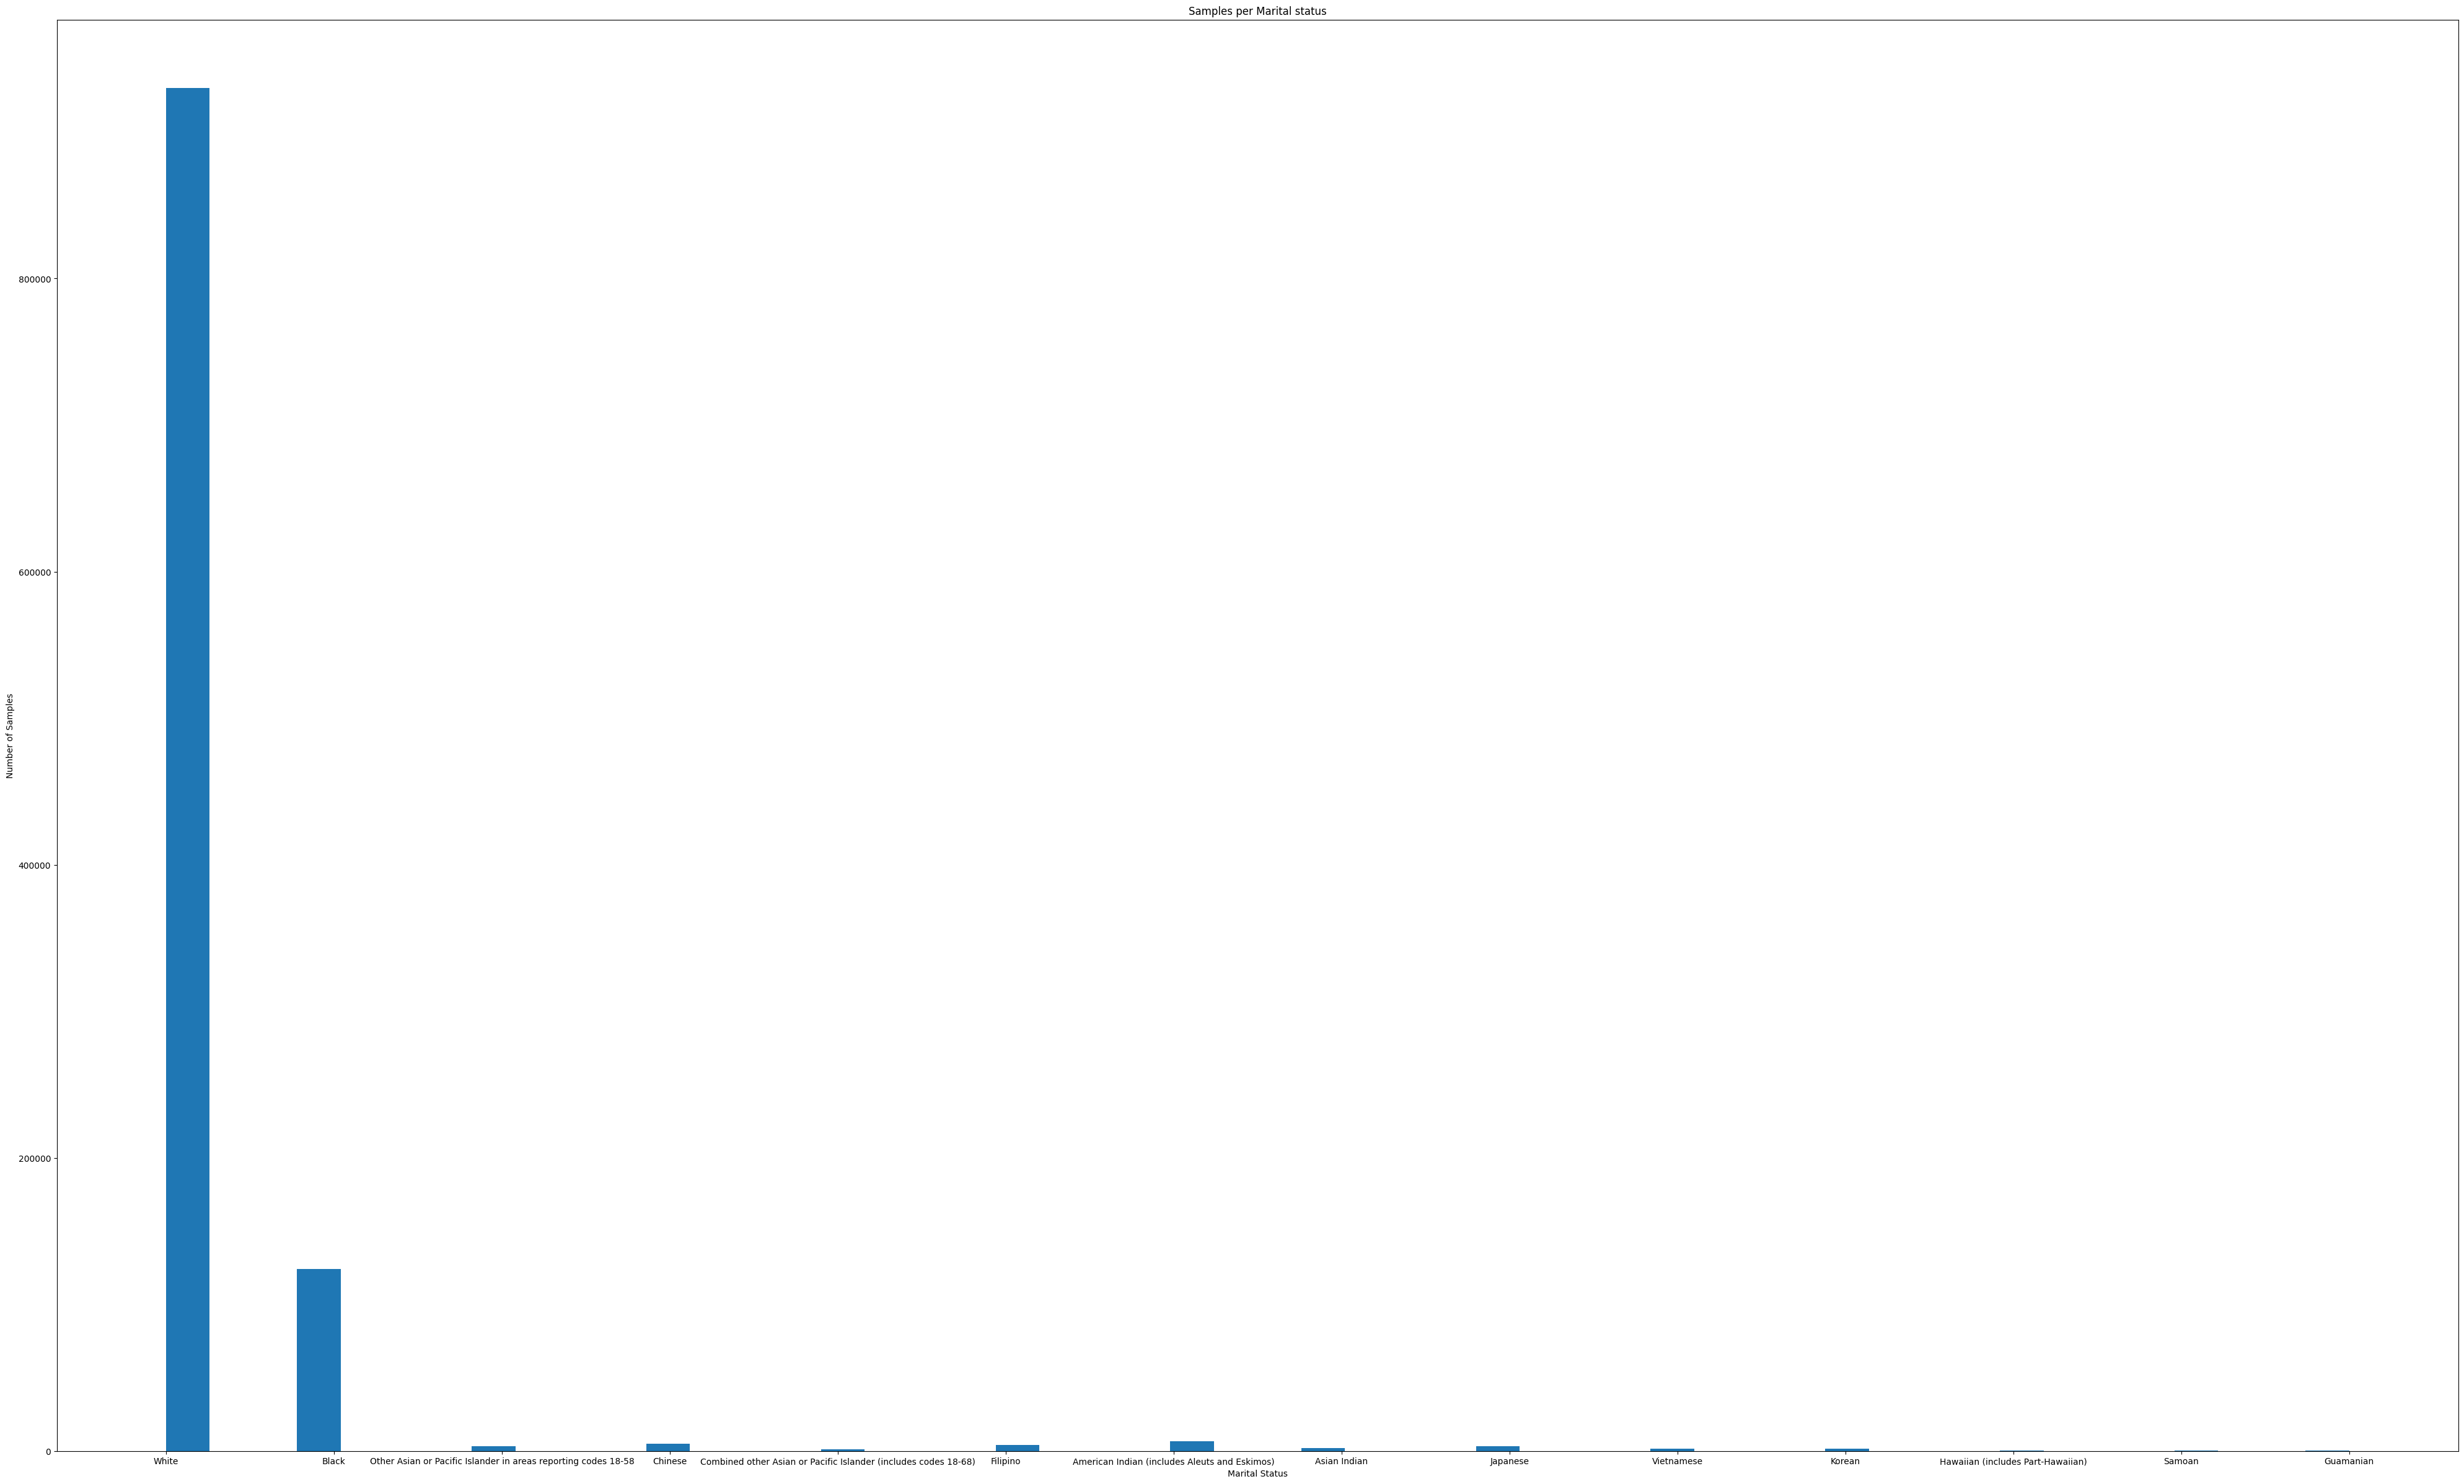

In [255]:
#Now adding Race into the mix
fig = plt.figure(figsize = (50, 30))
plt.title("Samples per Marital status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Samples")
plt.hist(marital_df['race'], bins = 50)
plt.show()

- This dataset is overwhelmingly white. Very very overwhelmingly white.
- That being said I will make four datasets. One for white men and women, and one for black men and balck women as they are the second biggest data samples

In [256]:
race_df = marital_df[marital_df['race'].isin(['White', 'Black'])]

### Black and White males

In [257]:
r = Maledf.set_index(['race'])
f = Femaledf.set_index(['race'])

In [258]:
r.loc['Black'].groupby('marital_status')['detail_age'].mean().sort_values(ascending = False) 

marital_status
Widowed                   79.559588
Married                   66.946263
Divorced                  64.276095
Marital Status unknown    62.821853
Never married, single     49.228772
Name: detail_age, dtype: float64

In [259]:
r.loc['White'].groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   83.916908
Married                   73.173289
Marital Status unknown    65.168353
Divorced                  64.489123
Never married, single     53.333678
Name: detail_age, dtype: float64

- Both white and black men follow the trend of the male comprehensive data from the previous section. 
- However there are differences. Both groups live longer if they are married, but white men live ten times as longer while black men only live two years longer.

- As widowers Black men live 13 years longer than if they are married while white men live only ten years longer. 

- Even though the ages on most marital statuses differ both black and white men live around the same age if they are divorced. 

- Lastly if they are never married or single black men live an average of less than 50 years old while white men live until 53. 

### Black and White Females

In [260]:
f.loc['Black'].groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   81.962770
Marital Status unknown    68.581212
Divorced                  67.419942
Married                   63.859973
Never married, single     55.625843
Name: detail_age, dtype: float64

In [261]:
f.loc['White'].groupby('marital_status')['detail_age'].mean().sort_values(ascending = False)

marital_status
Widowed                   85.632816
Marital Status unknown    73.125876
Divorced                  70.065354
Married                   70.046640
Never married, single     65.834276
Name: detail_age, dtype: float64

- In this group the trends are a little different.

- Black women live longer if they are divorced, by almost 4 years. White women on the other hand only lve 0.02% longer if they are divorced than if they are married. And both average ages for divorced and married deceased white women are larger by 3 years for divorced and 7 years for married compared to black women

- Single white women also live an average of ten years longer than single black women 

- Black women, similar to black men have a large jump between being Widowed and the next largest average. There is an almost 14 year average difference between deceased black women who were divorced and those who were widowed

- White women have an even larger jump of 15 years if they outlive their partner

# Year, month, and day of the week

### Are you more or less likely to die on a certain day of the week?
- Are people more likely to die on Mondays, or the beginning of the week compared to the end of the week?
- I will be measuring this in percentages

In [262]:
timedf = fulldf.loc[:, ['day_of_week_of_death', 'Year']]
#marital_df = fulldf.loc[:,['marital_status', 'race', 'sex','detail_age','Year']]

In [263]:
year = timedf.set_index('Year')

numlist = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015] 

numlistdf = pd.DataFrame()
#place_of_death_and_decedents_status
for i in numlist:
    numlistdf[i] = value_counting(i, 12, year)
#marlistdf
numlistdf

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
day_of_week_of_death,,,,,,,,,,,
Sat,14.687791,14.258281,14.317864,14.433732,14.280284,14.465472,14.855823,14.254851,14.294288,14.468630,14.267852
Mon,14.358728,14.244279,14.523905,14.197704,14.274283,14.314435,14.413739,14.574915,14.200266,14.152529,14.250848
Fri,14.318721,14.389302,14.300860,14.412730,14.261280,14.826558,14.304718,14.259852,14.582354,14.153529,14.299861
Thur,14.234705,14.273284,14.215843,14.241709,14.497334,14.132392,14.260710,14.246849,14.242276,14.153529,14.574935
Sun,14.223703,14.317291,14.042809,14.151698,14.104244,14.036369,14.014663,14.487898,14.097242,14.389605,14.348874
Tue,14.165691,14.316291,14.251850,14.325719,14.167258,14.103385,13.969654,13.993799,14.396311,14.261564,14.212837
Wed,14.009662,14.199272,14.345869,14.232708,14.409314,14.117388,14.167692,14.176835,14.183262,14.415613,14.040791
NA,0.001000,0.002000,0.001000,0.004000,0.006001,0.004001,0.013002,0.005001,0.004001,0.005002,0.004001


- What we can observe from the data is that there is no difference in between day of the week and when somebody dies. All of the data points seem to be evenly distributed more or less.


- There do not seem to be any significant changes in year either. So no day of the week is safe. 

#### What about each month?

In [264]:
monthdf = fulldf.loc[:, ['month_of_death', 'Year']]

In [265]:
myear = monthdf.set_index('Year')
monthdfdisp = pd.DataFrame()
for i in numlist:
    monthdfdisp[i] = value_counting(i, 12, myear)
#marlistdf
monthdfdisp

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
month_of_death,,,,,,,,,,,
March,9.536812,9.263482,8.979796,9.367124,8.679996,9.067176,9.063722,8.841768,9.003071,8.652769,9.084453
January,9.343775,9.013442,9.091818,8.915070,9.204117,8.881131,9.356778,8.807762,9.920282,9.301977,9.896672
December,9.049719,8.901424,8.899780,8.843061,8.907049,9.247219,8.660646,9.150830,8.722006,9.317982,8.549308
February,8.743661,8.324332,8.478696,9.111093,8.345920,8.048932,8.451606,8.223645,8.493954,7.982554,8.307243
April,8.294576,8.256321,8.280656,8.330000,8.294908,8.215972,8.100539,8.147630,8.261900,8.143606,8.387265
May,8.264570,8.341335,8.327666,8.322999,8.153875,8.245979,8.238565,8.210642,8.068856,8.223632,8.353255
October,8.207559,8.453353,8.246649,7.977957,8.453944,8.400016,8.211560,8.414683,8.265901,8.245639,8.235224
November,8.065532,8.259321,8.479696,8.141977,8.323915,8.214972,8.210560,8.415683,8.195885,8.485715,8.109189
July,7.804483,8.028285,7.930586,7.709925,8.054853,8.068937,8.000520,8.119624,7.919822,7.967550,8.032169


- Interestingly enough there does seem to be a slight difference in between months, but primarily over seasons it seems
- Summer months consistently have had the lowest rates of death in the dataset, which has spanned ten years. 
- However, fall winter and spring are all over the place in the dataset. Winter months are grouped up towards the top but March seems to be the most dangerous month.
- Spring months have higher rates of death than 50% of the dataset, and fall and summer are towards the bottom.
- Cold months aren't good for the elderly usually, but it surprises me that spring is rated above fall.

### What are the most common diseases for each year?

Lastly, I will look at the trends for most commond diseases per year. 

In [266]:
diseasedf = fulldf.loc[:, ['358_cause_recode', 'Year']]

In [267]:
diseasedf

,358_cause_recode,Year
0,"All other and unspecified accidents (W20-W31,W35-W38,W41-W64,W92-W99,X20-X32,X39,X50-X59,Y86)",2005
1,"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",2005
2,Colon (C18),2005
3,Rectosigmoid junction and rectum (C19-C20),2005
4,Other ill-defined and unknown causes of mortality (R96-R99),2005
...,...,...
1099995,Parkinson=s disease (G20-G21),2015
1099996,"Of trachea, bronchus and lung (C33-C34)",2015
1099997,Acute myocardial infarction (I21-I22),2015
1099998,"Organic dementia (F01,F03)",2015


In [268]:
disdf = diseasedf.set_index('Year')
def value_counts_year(column): #I'll have to update a dictionary with the percentages
    q = disdf.loc[column].value_counts()[:10]
    z = disdf.loc[column].shape[0]
    return q/z*100

In [269]:
dislist_df = pd.DataFrame()
for i in numlist:

    dislist_df[i] = value_counts_year(i)
#marlistdf
dislist_df


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
358_cause_recode,,,,,,,,,,,
"All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",9.394785,9.075452,8.758752,8.459015,8.226892,7.748860,7.781478,7.543509,7.293678,7.070262,7.015894
"Of trachea, bronchus and lung (C33-C34)",6.550245,6.476036,6.439288,6.415770,6.572512,6.332520,6.026145,6.100220,5.964372,6.026929,5.742550
Acute myocardial infarction (I21-I22),6.207179,5.780925,5.452090,5.511661,4.996149,4.961191,4.769906,4.691938,4.573052,4.404409,4.234143
Other chronic obstructive pulmonary disease (J44),4.596873,4.402704,4.546909,5.087611,4.911130,5.066216,5.080965,4.977996,5.290217,5.197663,5.265422
Diabetes mellitus (E10-E14),3.054580,2.958473,2.869574,2.870344,2.910669,2.862687,2.947560,2.819564,2.975684,2.848912,2.985806
"Stroke, not specified as hemorrhage or infarction (I64)",2.929557,3.028485,2.937588,2.824339,2.721626,2.785669,2.738520,2.605521,2.525581,2.502801,2.357637
Alzheimer=s disease (G30),2.853542,2.977476,3.153631,3.392407,3.203737,3.279787,3.384643,3.373675,3.221741,3.490117,4.177128
"Atherosclerotic cardiovascular disease, so described (I25.0)",2.635501,2.506401,2.453491,2.410289,2.408554,2.401576,2.328442,2.318464,2.341539,2.380762,2.165585
Congestive heart failure (I50.0),2.275432,2.347376,2.188438,2.076249,2.098483,2.083500,2.106400,2.129426,2.276524,2.358755,2.384644


In [270]:
indices = dislist_df.index.tolist()

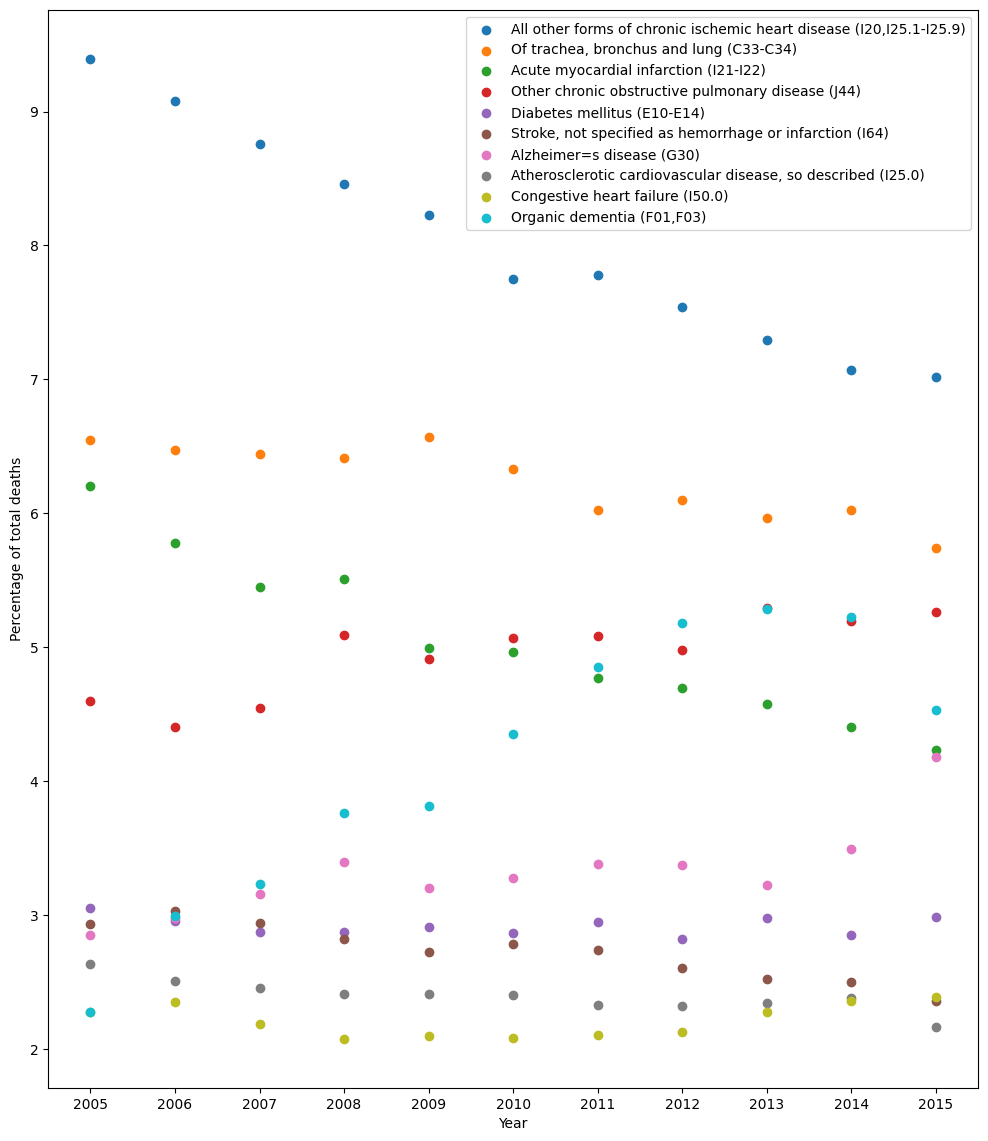

In [271]:
index_list = [] #all of the indices in the list had parantheses so I had to remove them
newnumlist = ['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
for i in indices:
  for j in i:
    index_list.append(j)
    plt.scatter(newnumlist, dislist_df.loc[j])
plt.legend(index_list, loc = 'best')


plt.xlabel('Year')
plt.ylabel('Percentage of total deaths')
plt.gcf().set_size_inches((12,14))
plt.show()


- For this final graph we can observe distinct changes over the years for each disease
- Chronic ischemic heart disease has been steadily going down over time and taking less of a percentage of deaths per year since 2005
- Bronchus, lung, and trachea causes of death have slowly been decreasing as well but not by much, same as heart attacks
- Alzihmer's and Dementia on the other hand have been shooting up in terms of causes of death. This could be a sign of people dying at older ages instead of just obesity related causes
- Cardiovascular disease, heart failure, stroke, and diabetes have all stayed constant while chronic pulmonary diseases are rising since 2005 in terms of percentage of total deaths

- All in all it seems that these deaths are indicative of people dying at older ages than they were before!
- Thank you for taking the time to read my project